In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time
import tqdm
import json
import torch
import warnings
import numpy as np
from datetime import datetime
from toolz.curried import pipe, curry, compose

warnings.filterwarnings('ignore')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

In [4]:
import chnet.utilities as utils
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
from chnet.torchsummary import summary
from chnet.ch_loader import CahnHillDataset

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## Loss Functions

In [6]:
@curry
def mse_loss(y1, y2, scale=1.):
    """standard MSE definition"""
    return ((y1 - y2) ** 2).sum() / y1.data.nelement() * scale

@curry
def rmse_loss(y1, y2, scale=1.):
    """standard RMSE definition"""
    return ((((y1 - y2) ** 2).sum() / y1.data.nelement()).sqrt()) * scale


def mse_loss_npy(y1, y2):
    """standard MSE definition"""
    return np.sum(((y1 - y2) ** 2)) / y1.size

## Data Generators

In [7]:
@curry
def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.05, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.98, 0.98, out=x_data)
    
    return x_data

@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=1, 
                   delta_sim_steps = 100,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   n_step = 4,
                   device = torch.device("cuda:0")):
    
    init_data = init_norm(nsamples, dim_x, dim_x, seed=seed)   

    x_data = ch.ch_run_torch(init_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, 
                             device=device)    

    y_data = ch.ch_run_torch(x_data, 
                             dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, 
                             device=device)    
    return x_data, y_data

# Set Device

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Model

In [9]:
x_data, y_data = data_generator(nsamples=4, 
                                dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps=50,
                                dx=0.25, 
                                dt=0.01,
                                gamma=1.0, 
                                seed=None,
                                device=device)

transformer_x = lambda x: x[None]
transformer_y = lambda x: x[None]

dataset = CahnHillDataset(x_data, y_data, transform_x=transformer_x, transform_y=transformer_y)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)

print(x.shape, y.shape)

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


In [10]:
from chnet.lstm_unet import Unet_rnn
model = Unet_rnn(input_nc=1, output_nc=1, ngf=16, tanh=True, temporal=10).double().to(device)

item = dataset[0]
x = item["x"][None].to(device)
y = item["y"][None].to(device)
y_pred, y_pred_ = model(x)

assert y.shape == y_pred.shape
print(mse_loss(y, y_pred).data)

tensor(0.1050, device='cuda:0', dtype=torch.float64)


# Model Training

### Training and Validation data generation

In [11]:
## Process Parameters
dim_x=96
init_steps=1
delta_sim_steps=2500
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
seed_prd = 284296

n_samples_trn = 1024*5
n_samples_val = 256
n_samples_prd = 256

In [12]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =seed_trn,
                              device = device)

CPU times: user 26 s, sys: 25 s, total: 51 s
Wall time: 51.2 s


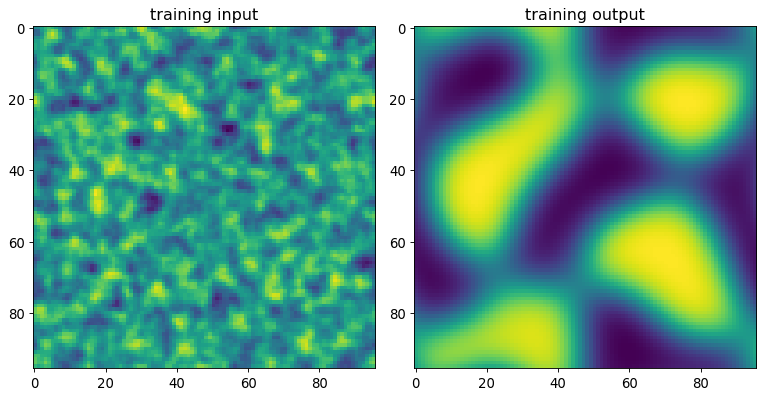

In [13]:
utils.draw_by_side([x_trn[0], y_trn[0]], sub_titles=["training input", "training output"])

In [14]:
trn_dataset = CahnHillDataset(x_trn, y_trn, transform_x=lambda x: x[None], transform_y=lambda x: x[None])

batch_size = 8
trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
total_step = len(trn_loader)
print("No. of training steps: %d" % total_step)

No. of training steps: 640


In [17]:
temporal=5
ngf = 16
from chnet.lstm_unet import Unet_rnn
model = Unet_rnn(input_nc=1, output_nc=1, ngf=ngf, tanh=True, temporal=temporal).double().to(device)
model.load_state_dict(torch.load("out/unet_rnn_ch16_1_2500.pt", map_location=device))

<All keys matched successfully>

In [18]:
criterion = mse_loss(scale=10000)
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trn_losses = []
val_losses = []

In [19]:
def get_primes(n):
    # https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n-in-python/3035188#3035188
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    sieve[0] = False
    for i in range(int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[      ((k*k)//3)      ::2*k] = False
            sieve[(k*k+4*k-2*k*(i&1))//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0]+1)|1)]

In [28]:
primes = get_primes(1000)

In [32]:
num_epochs = 5
# Loss and optimizer
for prime in primes:
    x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma*prime, 
                              seed =seed_trn,
                              device = device)
    for epoch in range(num_epochs):  
        torch.save(model.state_dict(), "out/unet_rnn_ch{}_{}_{}.pt".format(ngf, init_steps, delta_sim_steps))
        for i, item_trn in enumerate(tqdm.tqdm_notebook(trn_loader)):


            model.train()

            x = item_trn['x'].to(device)
            y_tru = item_trn['y'].to(device)

            # Forward pass
            y_prd, y_prd_ = model(x)
            loss = criterion(y_tru, y_prd)
            for e in range(temporal):
                loss += criterion(y_tru, y_prd_[:,e])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_losses.append(np.sqrt(loss.item()))

            if (i) % 512 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.11f}'.format(epoch+1, 
                                                                                     num_epochs, 
                                                                                     i+1, 
                                                                                     total_step, 
                                                                                     np.mean(trn_losses[-16:])))

Epoch [1/5], Step [1/640], Training Loss: 6.11446664547
Epoch [1/5], Step [513/640], Training Loss: 6.53968133081



Epoch [2/5], Step [1/640], Training Loss: 6.42149605106
Epoch [2/5], Step [513/640], Training Loss: 6.60916337341



Epoch [3/5], Step [1/640], Training Loss: 6.08579706870
Epoch [3/5], Step [513/640], Training Loss: 6.43143633548



Epoch [4/5], Step [1/640], Training Loss: 6.23941308451
Epoch [4/5], Step [513/640], Training Loss: 6.32640604244



Epoch [5/5], Step [1/640], Training Loss: 6.09393235184
Epoch [5/5], Step [513/640], Training Loss: 6.14917146897



Epoch [1/5], Step [1/640], Training Loss: 6.37822490059
Epoch [1/5], Step [513/640], Training Loss: 6.55297040635



Epoch [2/5], Step [1/640], Training Loss: 6.52797613989
Epoch [2/5], Step [513/640], Training Loss: 6.34655065692



Epoch [3/5], Step [1/640], Training Loss: 6.50245199553
Epoch [3/5], Step [513/640], Training Loss: 6.02050059583



Epoch [4/5], Step [1/640], Training Loss: 6.16192880547
Epoch [4/5], Step [513/640], Training Loss: 5.96463660317



Epoch [5/5], Step [1/640], Training Loss: 6.09262329955
Epoch [5/5], Step [513/640], Training Loss: 6.58422950104



Epoch [1/5], Step [1/640], Training Loss: 6.09743428614
Epoch [1/5], Step [513/640], Training Loss: 6.48996311365



Epoch [2/5], Step [1/640], Training Loss: 6.43878313497
Epoch [2/5], Step [513/640], Training Loss: 6.20419899407



Epoch [3/5], Step [1/640], Training Loss: 6.12003034649
Epoch [3/5], Step [513/640], Training Loss: 6.79495726443



Epoch [4/5], Step [1/640], Training Loss: 6.39925837033
Epoch [4/5], Step [513/640], Training Loss: 6.15508039235



Epoch [5/5], Step [1/640], Training Loss: 5.91651146538
Epoch [5/5], Step [513/640], Training Loss: 6.25993060433



Epoch [1/5], Step [1/640], Training Loss: 6.03940849262
Epoch [1/5], Step [513/640], Training Loss: 6.17916138107



Epoch [2/5], Step [1/640], Training Loss: 6.16876179750
Epoch [2/5], Step [513/640], Training Loss: 6.23004678615



Epoch [3/5], Step [1/640], Training Loss: 5.91073797428
Epoch [3/5], Step [513/640], Training Loss: 6.67487676761



Epoch [4/5], Step [1/640], Training Loss: 6.18974821199
Epoch [4/5], Step [513/640], Training Loss: 6.25004542284



Epoch [5/5], Step [1/640], Training Loss: 6.05371480333
Epoch [5/5], Step [513/640], Training Loss: 6.45455212185



Epoch [1/5], Step [1/640], Training Loss: 6.29356154214
Epoch [1/5], Step [513/640], Training Loss: 6.35968405264



Epoch [2/5], Step [1/640], Training Loss: 6.13154604693
Epoch [2/5], Step [513/640], Training Loss: 6.19874882880



Epoch [3/5], Step [1/640], Training Loss: 6.06804687629
Epoch [3/5], Step [513/640], Training Loss: 5.90007452065



Epoch [4/5], Step [1/640], Training Loss: 6.11898417341
Epoch [4/5], Step [513/640], Training Loss: 6.03658309457



Epoch [5/5], Step [1/640], Training Loss: 5.98747991012
Epoch [5/5], Step [513/640], Training Loss: 6.02693184513



Epoch [1/5], Step [1/640], Training Loss: 6.07731539539
Epoch [1/5], Step [513/640], Training Loss: 6.61757848929



Epoch [2/5], Step [1/640], Training Loss: 6.06595667169
Epoch [2/5], Step [513/640], Training Loss: 5.95432107107



Epoch [3/5], Step [1/640], Training Loss: 5.53362022583
Epoch [3/5], Step [513/640], Training Loss: 6.45950398109



Epoch [4/5], Step [1/640], Training Loss: 5.87623790820
Epoch [4/5], Step [513/640], Training Loss: 5.84288660430



Epoch [5/5], Step [1/640], Training Loss: 5.77078272176
Epoch [5/5], Step [513/640], Training Loss: 6.17331161141



Epoch [1/5], Step [1/640], Training Loss: 6.53765356583
Epoch [1/5], Step [513/640], Training Loss: 6.54249641777



Epoch [2/5], Step [1/640], Training Loss: 6.55446620009
Epoch [2/5], Step [513/640], Training Loss: 5.82188258701



Epoch [3/5], Step [1/640], Training Loss: 6.09558160764
Epoch [3/5], Step [513/640], Training Loss: 6.23410367643



Epoch [4/5], Step [1/640], Training Loss: 6.17098998615
Epoch [4/5], Step [513/640], Training Loss: 6.11587709583



Epoch [5/5], Step [1/640], Training Loss: 5.89751524008
Epoch [5/5], Step [513/640], Training Loss: 6.35404459098



Epoch [1/5], Step [1/640], Training Loss: 6.11269931219
Epoch [1/5], Step [513/640], Training Loss: 6.39972270459



Epoch [2/5], Step [1/640], Training Loss: 5.97209322475
Epoch [2/5], Step [513/640], Training Loss: 5.95888797809



Epoch [3/5], Step [1/640], Training Loss: 5.89314858043
Epoch [3/5], Step [513/640], Training Loss: 5.77963533602



Epoch [4/5], Step [1/640], Training Loss: 6.35348264563
Epoch [4/5], Step [513/640], Training Loss: 5.89196693056



Epoch [5/5], Step [1/640], Training Loss: 5.77957870168
Epoch [5/5], Step [513/640], Training Loss: 5.96678983804



Epoch [1/5], Step [1/640], Training Loss: 5.55174176700
Epoch [1/5], Step [513/640], Training Loss: 5.89631858980



Epoch [2/5], Step [1/640], Training Loss: 6.21575871475
Epoch [2/5], Step [513/640], Training Loss: 6.19321518384



Epoch [3/5], Step [1/640], Training Loss: 5.77213425079
Epoch [3/5], Step [513/640], Training Loss: 5.95102342473



Epoch [4/5], Step [1/640], Training Loss: 6.02362281011
Epoch [4/5], Step [513/640], Training Loss: 6.07308386403



Epoch [5/5], Step [1/640], Training Loss: 6.14978965176
Epoch [5/5], Step [513/640], Training Loss: 6.24471170316



Epoch [1/5], Step [1/640], Training Loss: 5.82946917088
Epoch [1/5], Step [513/640], Training Loss: 5.97220663244



Epoch [2/5], Step [1/640], Training Loss: 5.91819593936
Epoch [2/5], Step [513/640], Training Loss: 6.06477793981



Epoch [3/5], Step [1/640], Training Loss: 5.99877943560
Epoch [3/5], Step [513/640], Training Loss: 5.85109771976



Epoch [4/5], Step [1/640], Training Loss: 6.06614451229
Epoch [4/5], Step [513/640], Training Loss: 5.66611886055



Epoch [5/5], Step [1/640], Training Loss: 5.90633440030
Epoch [5/5], Step [513/640], Training Loss: 5.87233147752



Epoch [1/5], Step [1/640], Training Loss: 5.89186146361
Epoch [1/5], Step [513/640], Training Loss: 5.86610449270



Epoch [2/5], Step [1/640], Training Loss: 6.14823012329
Epoch [2/5], Step [513/640], Training Loss: 5.83069277794



Epoch [3/5], Step [1/640], Training Loss: 6.11408484705
Epoch [3/5], Step [513/640], Training Loss: 5.96712152755



Epoch [4/5], Step [1/640], Training Loss: 5.55983644077
Epoch [4/5], Step [513/640], Training Loss: 5.95265856971



Epoch [5/5], Step [1/640], Training Loss: 5.74669070160
Epoch [5/5], Step [513/640], Training Loss: 5.93733073839



Epoch [1/5], Step [1/640], Training Loss: 5.96037144336
Epoch [1/5], Step [513/640], Training Loss: 5.64100623025



Epoch [2/5], Step [1/640], Training Loss: 5.82893459613
Epoch [2/5], Step [513/640], Training Loss: 6.03280751604



Epoch [3/5], Step [1/640], Training Loss: 5.73183540708
Epoch [3/5], Step [513/640], Training Loss: 6.33927850631



Epoch [4/5], Step [1/640], Training Loss: 6.25504355733
Epoch [4/5], Step [513/640], Training Loss: 5.65823578545



Epoch [5/5], Step [1/640], Training Loss: 5.79227272851
Epoch [5/5], Step [513/640], Training Loss: 6.05986413657



Epoch [1/5], Step [1/640], Training Loss: 5.78998037292
Epoch [1/5], Step [513/640], Training Loss: 6.01104001826



Epoch [2/5], Step [1/640], Training Loss: 6.08438398471
Epoch [2/5], Step [513/640], Training Loss: 5.80215895512



Epoch [3/5], Step [1/640], Training Loss: 5.89696284859
Epoch [3/5], Step [513/640], Training Loss: 6.14979078050



Epoch [4/5], Step [1/640], Training Loss: 5.79278688879
Epoch [4/5], Step [513/640], Training Loss: 6.00965094226



Epoch [5/5], Step [1/640], Training Loss: 5.79484634713
Epoch [5/5], Step [513/640], Training Loss: 5.98969914723



Epoch [1/5], Step [1/640], Training Loss: 5.73964070161
Epoch [1/5], Step [513/640], Training Loss: 5.91727956166



Epoch [2/5], Step [1/640], Training Loss: 5.50864873006
Epoch [2/5], Step [513/640], Training Loss: 6.24251815672



Epoch [3/5], Step [1/640], Training Loss: 5.92739263040
Epoch [3/5], Step [513/640], Training Loss: 5.87628328811



Epoch [4/5], Step [1/640], Training Loss: 5.58914888267
Epoch [4/5], Step [513/640], Training Loss: 5.87854239136



Epoch [5/5], Step [1/640], Training Loss: 5.72493639822
Epoch [5/5], Step [513/640], Training Loss: 5.82510959130



Epoch [1/5], Step [1/640], Training Loss: 5.85965561619
Epoch [1/5], Step [513/640], Training Loss: 6.48777357980



Epoch [2/5], Step [1/640], Training Loss: 6.28566069282
Epoch [2/5], Step [513/640], Training Loss: 5.58219626761



Epoch [3/5], Step [1/640], Training Loss: 5.78906038285
Epoch [3/5], Step [513/640], Training Loss: 5.99988463268



Epoch [4/5], Step [1/640], Training Loss: 6.17735811685
Epoch [4/5], Step [513/640], Training Loss: 5.87348183709



Epoch [5/5], Step [1/640], Training Loss: 5.90079440696
Epoch [5/5], Step [513/640], Training Loss: 6.24088469198



Epoch [1/5], Step [1/640], Training Loss: 6.06447035468
Epoch [1/5], Step [513/640], Training Loss: 6.52786510376



Epoch [2/5], Step [1/640], Training Loss: 6.03075479175
Epoch [2/5], Step [513/640], Training Loss: 5.80460907695



Epoch [3/5], Step [1/640], Training Loss: 5.70301546147
Epoch [3/5], Step [513/640], Training Loss: 5.63948429385



Epoch [4/5], Step [1/640], Training Loss: 5.84083392237
Epoch [4/5], Step [513/640], Training Loss: 5.99219775368



Epoch [5/5], Step [1/640], Training Loss: 5.78010219150
Epoch [5/5], Step [513/640], Training Loss: 5.76887353294



Epoch [1/5], Step [1/640], Training Loss: 5.67078412839
Epoch [1/5], Step [513/640], Training Loss: 5.89359861820



Epoch [2/5], Step [1/640], Training Loss: 5.97675895723
Epoch [2/5], Step [513/640], Training Loss: 5.70116912820



Epoch [3/5], Step [1/640], Training Loss: 6.57224136766
Epoch [3/5], Step [513/640], Training Loss: 5.69008162677



Epoch [4/5], Step [1/640], Training Loss: 5.88942413324
Epoch [4/5], Step [513/640], Training Loss: 5.90766816026



Epoch [5/5], Step [1/640], Training Loss: 5.58452589728
Epoch [5/5], Step [513/640], Training Loss: 5.71398026513



Epoch [1/5], Step [1/640], Training Loss: 5.66460612688
Epoch [1/5], Step [513/640], Training Loss: 5.92755159979



Epoch [2/5], Step [1/640], Training Loss: 5.75803704697
Epoch [2/5], Step [513/640], Training Loss: 5.78385314004



Epoch [3/5], Step [1/640], Training Loss: 5.97311266752
Epoch [3/5], Step [513/640], Training Loss: 5.76941189063



Epoch [4/5], Step [1/640], Training Loss: 5.73735119160
Epoch [4/5], Step [513/640], Training Loss: 5.73538243745



Epoch [5/5], Step [1/640], Training Loss: 6.06593836760
Epoch [5/5], Step [513/640], Training Loss: 5.90885425962



Epoch [1/5], Step [1/640], Training Loss: 5.85389882057
Epoch [1/5], Step [513/640], Training Loss: 6.04794421394



Epoch [2/5], Step [1/640], Training Loss: 5.81939351986
Epoch [2/5], Step [513/640], Training Loss: 6.14211380175



Epoch [3/5], Step [1/640], Training Loss: 5.67353350494
Epoch [3/5], Step [513/640], Training Loss: 6.05261299555



Epoch [4/5], Step [1/640], Training Loss: 5.46232500345
Epoch [4/5], Step [513/640], Training Loss: 5.60374693352



Epoch [5/5], Step [1/640], Training Loss: 5.54332377705
Epoch [5/5], Step [513/640], Training Loss: 6.12733400080



Epoch [1/5], Step [1/640], Training Loss: 5.69421593921
Epoch [1/5], Step [513/640], Training Loss: 5.69529518405



Epoch [2/5], Step [1/640], Training Loss: 5.61868272422
Epoch [2/5], Step [513/640], Training Loss: 5.84619818895



Epoch [3/5], Step [1/640], Training Loss: 5.96348282366
Epoch [3/5], Step [513/640], Training Loss: 5.72645057628



Epoch [4/5], Step [1/640], Training Loss: 5.78269127240
Epoch [4/5], Step [513/640], Training Loss: 5.46082395148



Epoch [5/5], Step [1/640], Training Loss: 5.55600059942
Epoch [5/5], Step [513/640], Training Loss: 5.97905145379



Epoch [1/5], Step [1/640], Training Loss: 5.71168950058
Epoch [1/5], Step [513/640], Training Loss: 6.49194599083



Epoch [2/5], Step [1/640], Training Loss: 5.54178149475
Epoch [2/5], Step [513/640], Training Loss: 5.65167022220



Epoch [3/5], Step [1/640], Training Loss: 5.97587251233
Epoch [3/5], Step [513/640], Training Loss: 5.88061794553



Epoch [4/5], Step [1/640], Training Loss: 5.62739972690
Epoch [4/5], Step [513/640], Training Loss: 6.04288896542



Epoch [5/5], Step [1/640], Training Loss: 5.62793605191
Epoch [5/5], Step [513/640], Training Loss: 6.33133129646



Epoch [1/5], Step [1/640], Training Loss: 5.65408135436
Epoch [1/5], Step [513/640], Training Loss: 5.78614181549



Epoch [2/5], Step [1/640], Training Loss: 5.88780390690
Epoch [2/5], Step [513/640], Training Loss: 5.57120057700



Epoch [3/5], Step [1/640], Training Loss: 5.74049641227
Epoch [3/5], Step [513/640], Training Loss: 5.62098096257



Epoch [4/5], Step [1/640], Training Loss: 5.71129832227
Epoch [4/5], Step [513/640], Training Loss: 5.75268315447



Epoch [5/5], Step [1/640], Training Loss: 5.67009087457
Epoch [5/5], Step [513/640], Training Loss: 5.79355885210



Epoch [1/5], Step [1/640], Training Loss: 5.70347623742
Epoch [1/5], Step [513/640], Training Loss: 5.62885173997



Epoch [2/5], Step [1/640], Training Loss: 5.40219037516
Epoch [2/5], Step [513/640], Training Loss: 5.68470970869



Epoch [3/5], Step [1/640], Training Loss: 5.52151546710
Epoch [3/5], Step [513/640], Training Loss: 6.07787120322



Epoch [4/5], Step [1/640], Training Loss: 5.77984202757
Epoch [4/5], Step [513/640], Training Loss: 5.92578310105



Epoch [5/5], Step [1/640], Training Loss: 5.40384615938
Epoch [5/5], Step [513/640], Training Loss: 5.64438147987



Epoch [1/5], Step [1/640], Training Loss: 6.08901383295
Epoch [1/5], Step [513/640], Training Loss: 5.78999166794



Epoch [2/5], Step [1/640], Training Loss: 5.94619898467
Epoch [2/5], Step [513/640], Training Loss: 5.83867839024



Epoch [3/5], Step [1/640], Training Loss: 5.67423170732
Epoch [3/5], Step [513/640], Training Loss: 6.02061251305



Epoch [4/5], Step [1/640], Training Loss: 5.58839498484
Epoch [4/5], Step [513/640], Training Loss: 5.49936682682



Epoch [5/5], Step [1/640], Training Loss: 5.62941740415
Epoch [5/5], Step [513/640], Training Loss: 5.65797560213



Epoch [1/5], Step [1/640], Training Loss: 5.41058440633
Epoch [1/5], Step [513/640], Training Loss: 6.05692723684



Epoch [2/5], Step [1/640], Training Loss: 5.74616008348
Epoch [2/5], Step [513/640], Training Loss: 5.76199753797



Epoch [3/5], Step [1/640], Training Loss: 5.38138182146
Epoch [3/5], Step [513/640], Training Loss: 5.27258879338



Epoch [4/5], Step [1/640], Training Loss: 5.70895180962
Epoch [4/5], Step [513/640], Training Loss: 5.53801016723



Epoch [5/5], Step [1/640], Training Loss: 5.44970952767
Epoch [5/5], Step [513/640], Training Loss: 6.85036721580



Epoch [1/5], Step [1/640], Training Loss: 5.65125825417
Epoch [1/5], Step [513/640], Training Loss: 5.55623303796



Epoch [2/5], Step [1/640], Training Loss: 5.62574984662
Epoch [2/5], Step [513/640], Training Loss: 5.96338209432



Epoch [3/5], Step [1/640], Training Loss: 5.50833851376
Epoch [3/5], Step [513/640], Training Loss: 5.61347668655



Epoch [4/5], Step [1/640], Training Loss: 5.87211866052
Epoch [4/5], Step [513/640], Training Loss: 5.55305633362



Epoch [5/5], Step [1/640], Training Loss: 5.40383180587
Epoch [5/5], Step [513/640], Training Loss: 5.87485798168



Epoch [1/5], Step [1/640], Training Loss: 5.84956271273
Epoch [1/5], Step [513/640], Training Loss: 5.53219878446



Epoch [2/5], Step [1/640], Training Loss: 6.06333163821
Epoch [2/5], Step [513/640], Training Loss: 5.60140604859



Epoch [3/5], Step [1/640], Training Loss: 5.55018438313
Epoch [3/5], Step [513/640], Training Loss: 5.54743642240



Epoch [4/5], Step [1/640], Training Loss: 5.80331826530
Epoch [4/5], Step [513/640], Training Loss: 5.68268087977



Epoch [5/5], Step [1/640], Training Loss: 5.51439971096
Epoch [5/5], Step [513/640], Training Loss: 5.63728192689



Epoch [1/5], Step [1/640], Training Loss: 5.39082113984
Epoch [1/5], Step [513/640], Training Loss: 5.37712212689



Epoch [2/5], Step [1/640], Training Loss: 5.51287781944
Epoch [2/5], Step [513/640], Training Loss: 5.45222541672



Epoch [3/5], Step [1/640], Training Loss: 5.77247778812
Epoch [3/5], Step [513/640], Training Loss: 5.59855840593



Epoch [4/5], Step [1/640], Training Loss: 5.26664809986
Epoch [4/5], Step [513/640], Training Loss: 5.77664453663



Epoch [5/5], Step [1/640], Training Loss: 5.47402373192
Epoch [5/5], Step [513/640], Training Loss: 5.43346866393



Epoch [1/5], Step [1/640], Training Loss: 5.33440221687
Epoch [1/5], Step [513/640], Training Loss: 6.18579377527



Epoch [2/5], Step [1/640], Training Loss: 5.39391557921
Epoch [2/5], Step [513/640], Training Loss: 5.52418727872



Epoch [3/5], Step [1/640], Training Loss: 5.56327509270
Epoch [3/5], Step [513/640], Training Loss: 5.27848650664



Epoch [4/5], Step [1/640], Training Loss: 5.57192804481
Epoch [4/5], Step [513/640], Training Loss: 5.68588443093



Epoch [5/5], Step [1/640], Training Loss: 5.25123171000
Epoch [5/5], Step [513/640], Training Loss: 5.87465920412



Epoch [1/5], Step [1/640], Training Loss: 5.42635273855
Epoch [1/5], Step [513/640], Training Loss: 5.54973953576



Epoch [2/5], Step [1/640], Training Loss: 5.30382635497
Epoch [2/5], Step [513/640], Training Loss: 5.87365255905



Epoch [3/5], Step [1/640], Training Loss: 5.63635022893
Epoch [3/5], Step [513/640], Training Loss: 5.69598987924



Epoch [4/5], Step [1/640], Training Loss: 5.51114786107
Epoch [4/5], Step [513/640], Training Loss: 5.51689634553



Epoch [5/5], Step [1/640], Training Loss: 5.73655979049
Epoch [5/5], Step [513/640], Training Loss: 5.66731488078



Epoch [1/5], Step [1/640], Training Loss: 6.00158713921
Epoch [1/5], Step [513/640], Training Loss: 5.54806241018



Epoch [2/5], Step [1/640], Training Loss: 5.64838640318
Epoch [2/5], Step [513/640], Training Loss: 5.28734173841



Epoch [3/5], Step [1/640], Training Loss: 5.60103730591
Epoch [3/5], Step [513/640], Training Loss: 5.33719012452



Epoch [4/5], Step [1/640], Training Loss: 5.41584573471
Epoch [4/5], Step [513/640], Training Loss: 5.38705943663



Epoch [5/5], Step [1/640], Training Loss: 5.64680776213
Epoch [5/5], Step [513/640], Training Loss: 5.55170161558



Epoch [1/5], Step [1/640], Training Loss: 5.34276736581
Epoch [1/5], Step [513/640], Training Loss: 5.36578421992



Epoch [2/5], Step [1/640], Training Loss: 5.26499840454
Epoch [2/5], Step [513/640], Training Loss: 5.51243815400



Epoch [3/5], Step [1/640], Training Loss: 6.30991632870
Epoch [3/5], Step [513/640], Training Loss: 5.38618913322



Epoch [4/5], Step [1/640], Training Loss: 5.32825118982
Epoch [4/5], Step [513/640], Training Loss: 5.42646209203



Epoch [5/5], Step [1/640], Training Loss: 5.45133870657
Epoch [5/5], Step [513/640], Training Loss: 5.54299500551



Epoch [1/5], Step [1/640], Training Loss: 5.76011575816
Epoch [1/5], Step [513/640], Training Loss: 5.72235173671



Epoch [2/5], Step [1/640], Training Loss: 5.51899455138
Epoch [2/5], Step [513/640], Training Loss: 5.41068664502



Epoch [3/5], Step [1/640], Training Loss: 5.27090826605
Epoch [3/5], Step [513/640], Training Loss: 5.23776187462



Epoch [4/5], Step [1/640], Training Loss: 5.49667374206
Epoch [4/5], Step [513/640], Training Loss: 5.24945224554



Epoch [5/5], Step [1/640], Training Loss: 5.35841694330
Epoch [5/5], Step [513/640], Training Loss: 5.45469338933



Epoch [1/5], Step [1/640], Training Loss: 5.66948035850
Epoch [1/5], Step [513/640], Training Loss: 5.48759706345



Epoch [2/5], Step [1/640], Training Loss: 5.21606903357
Epoch [2/5], Step [513/640], Training Loss: 5.65718674652



Epoch [3/5], Step [1/640], Training Loss: 5.42791367206
Epoch [3/5], Step [513/640], Training Loss: 5.62284861977



Epoch [4/5], Step [1/640], Training Loss: 5.74098131347
Epoch [4/5], Step [513/640], Training Loss: 5.35070413050



Epoch [5/5], Step [1/640], Training Loss: 5.39976095655
Epoch [5/5], Step [513/640], Training Loss: 5.87983850777



Epoch [1/5], Step [1/640], Training Loss: 5.67979572142
Epoch [1/5], Step [513/640], Training Loss: 5.50081597764



Epoch [2/5], Step [1/640], Training Loss: 5.45928669310
Epoch [2/5], Step [513/640], Training Loss: 5.50977370694



Epoch [3/5], Step [1/640], Training Loss: 5.59974109432
Epoch [3/5], Step [513/640], Training Loss: 6.77214267945



Epoch [4/5], Step [1/640], Training Loss: 5.58892823494
Epoch [4/5], Step [513/640], Training Loss: 5.63907921527



Epoch [5/5], Step [1/640], Training Loss: 5.35240451837
Epoch [5/5], Step [513/640], Training Loss: 5.62526060042



Epoch [1/5], Step [1/640], Training Loss: 5.54665689732
Epoch [1/5], Step [513/640], Training Loss: 5.60694005671



Epoch [2/5], Step [1/640], Training Loss: 5.64077375563
Epoch [2/5], Step [513/640], Training Loss: 5.54117126149



Epoch [3/5], Step [1/640], Training Loss: 5.57951873834
Epoch [3/5], Step [513/640], Training Loss: 5.23826669338



Epoch [4/5], Step [1/640], Training Loss: 5.31651797153
Epoch [4/5], Step [513/640], Training Loss: 5.36677225258



Epoch [5/5], Step [1/640], Training Loss: 5.44791809105
Epoch [5/5], Step [513/640], Training Loss: 5.19790488572



Epoch [1/5], Step [1/640], Training Loss: 5.78769880552
Epoch [1/5], Step [513/640], Training Loss: 5.78170514352



Epoch [2/5], Step [1/640], Training Loss: 5.51515008943
Epoch [2/5], Step [513/640], Training Loss: 5.41143046962



Epoch [3/5], Step [1/640], Training Loss: 5.74307210692
Epoch [3/5], Step [513/640], Training Loss: 5.24040744897



Epoch [4/5], Step [1/640], Training Loss: 5.43536026793
Epoch [4/5], Step [513/640], Training Loss: 5.25823338594



Epoch [5/5], Step [1/640], Training Loss: 5.50152722608
Epoch [5/5], Step [513/640], Training Loss: 5.23724346670



Epoch [1/5], Step [1/640], Training Loss: 5.91643652959
Epoch [1/5], Step [513/640], Training Loss: 5.32599749955



Epoch [2/5], Step [1/640], Training Loss: 5.43194086632
Epoch [2/5], Step [513/640], Training Loss: 5.45416016683



Epoch [3/5], Step [1/640], Training Loss: 5.21069303618
Epoch [3/5], Step [513/640], Training Loss: 5.45073635330



Epoch [4/5], Step [1/640], Training Loss: 5.22615168911
Epoch [4/5], Step [513/640], Training Loss: 5.08733353383



Epoch [5/5], Step [1/640], Training Loss: 5.16587566733
Epoch [5/5], Step [513/640], Training Loss: 5.61870173358



Epoch [1/5], Step [1/640], Training Loss: 5.27315559996
Epoch [1/5], Step [513/640], Training Loss: 5.43006338852



Epoch [2/5], Step [1/640], Training Loss: 5.59371252090
Epoch [2/5], Step [513/640], Training Loss: 5.40199051114



Epoch [3/5], Step [1/640], Training Loss: 5.43901937955
Epoch [3/5], Step [513/640], Training Loss: 5.43426826787



Epoch [4/5], Step [1/640], Training Loss: 5.27115719400
Epoch [4/5], Step [513/640], Training Loss: 5.20206191862



Epoch [5/5], Step [1/640], Training Loss: 5.57244528410
Epoch [5/5], Step [513/640], Training Loss: 5.57975305750



Epoch [1/5], Step [1/640], Training Loss: 5.87598093984
Epoch [1/5], Step [513/640], Training Loss: 5.49973654049



Epoch [2/5], Step [1/640], Training Loss: 5.58491847804
Epoch [2/5], Step [513/640], Training Loss: 5.15330687094



Epoch [3/5], Step [1/640], Training Loss: 4.98820601059
Epoch [3/5], Step [513/640], Training Loss: 5.12397652205



Epoch [4/5], Step [1/640], Training Loss: 5.23286729255
Epoch [4/5], Step [513/640], Training Loss: 5.42278410634



Epoch [5/5], Step [1/640], Training Loss: 5.59235266949
Epoch [5/5], Step [513/640], Training Loss: 5.16611125387



Epoch [1/5], Step [1/640], Training Loss: 5.28267965143
Epoch [1/5], Step [513/640], Training Loss: 5.29292045638



Epoch [2/5], Step [1/640], Training Loss: 5.21819446267
Epoch [2/5], Step [513/640], Training Loss: 5.13045005969



Epoch [3/5], Step [1/640], Training Loss: 5.34461172119
Epoch [3/5], Step [513/640], Training Loss: 5.22457960494



Epoch [4/5], Step [1/640], Training Loss: 5.20163050924
Epoch [4/5], Step [513/640], Training Loss: 5.72590298330



Epoch [5/5], Step [1/640], Training Loss: 5.08530792956
Epoch [5/5], Step [513/640], Training Loss: 5.29948448982



Epoch [1/5], Step [1/640], Training Loss: 5.23375763085
Epoch [1/5], Step [513/640], Training Loss: 5.38649037714



Epoch [2/5], Step [1/640], Training Loss: 5.25123397375
Epoch [2/5], Step [513/640], Training Loss: 5.10985468862



Epoch [3/5], Step [1/640], Training Loss: 5.46879155152
Epoch [3/5], Step [513/640], Training Loss: 5.65946171545



Epoch [4/5], Step [1/640], Training Loss: 5.87503079064
Epoch [4/5], Step [513/640], Training Loss: 5.88179769790



Epoch [5/5], Step [1/640], Training Loss: 5.23549894428
Epoch [5/5], Step [513/640], Training Loss: 5.21169012307



Epoch [1/5], Step [1/640], Training Loss: 5.28877554648
Epoch [1/5], Step [513/640], Training Loss: 5.18890845514



Epoch [2/5], Step [1/640], Training Loss: 5.20562719685
Epoch [2/5], Step [513/640], Training Loss: 5.84802296781



Epoch [3/5], Step [1/640], Training Loss: 5.67145333679
Epoch [3/5], Step [513/640], Training Loss: 5.57014338993



Epoch [4/5], Step [1/640], Training Loss: 5.25576511377
Epoch [4/5], Step [513/640], Training Loss: 5.74850408057



Epoch [5/5], Step [1/640], Training Loss: 5.45138644580
Epoch [5/5], Step [513/640], Training Loss: 5.27934608959



Epoch [1/5], Step [1/640], Training Loss: 5.12185911235
Epoch [1/5], Step [513/640], Training Loss: 5.36556715702



Epoch [2/5], Step [1/640], Training Loss: 5.46407645557
Epoch [2/5], Step [513/640], Training Loss: 5.40064746211



Epoch [3/5], Step [1/640], Training Loss: 5.18157171523
Epoch [3/5], Step [513/640], Training Loss: 5.22110776643



Epoch [4/5], Step [1/640], Training Loss: 5.21639224874
Epoch [4/5], Step [513/640], Training Loss: 5.37439958564



Epoch [5/5], Step [1/640], Training Loss: 5.31853316227
Epoch [5/5], Step [513/640], Training Loss: 5.28437640709



Epoch [1/5], Step [1/640], Training Loss: 5.46379562295
Epoch [1/5], Step [513/640], Training Loss: 5.27803409658



Epoch [2/5], Step [1/640], Training Loss: 5.25001508806
Epoch [2/5], Step [513/640], Training Loss: 5.24768515549



Epoch [3/5], Step [1/640], Training Loss: 5.13632997359
Epoch [3/5], Step [513/640], Training Loss: 5.43704391545



Epoch [4/5], Step [1/640], Training Loss: 5.16449305886
Epoch [4/5], Step [513/640], Training Loss: 5.27335610900



Epoch [5/5], Step [1/640], Training Loss: 5.20334910635
Epoch [5/5], Step [513/640], Training Loss: 5.40689004700



Epoch [1/5], Step [1/640], Training Loss: 5.45475753622
Epoch [1/5], Step [513/640], Training Loss: 5.01221086566



Epoch [2/5], Step [1/640], Training Loss: 5.61365031171
Epoch [2/5], Step [513/640], Training Loss: 5.05192445618



Epoch [3/5], Step [1/640], Training Loss: 5.62262294361
Epoch [3/5], Step [513/640], Training Loss: 5.40877849433



Epoch [4/5], Step [1/640], Training Loss: 5.46020388703
Epoch [4/5], Step [513/640], Training Loss: 5.22520235123



Epoch [5/5], Step [1/640], Training Loss: 5.31437221333
Epoch [5/5], Step [513/640], Training Loss: 5.36790190201



Epoch [1/5], Step [1/640], Training Loss: 5.33532670063
Epoch [1/5], Step [513/640], Training Loss: 5.25614533110



Epoch [2/5], Step [1/640], Training Loss: 5.32507911028
Epoch [2/5], Step [513/640], Training Loss: 5.58369461531



Epoch [3/5], Step [1/640], Training Loss: 4.91288365335
Epoch [3/5], Step [513/640], Training Loss: 4.93474109314



Epoch [4/5], Step [1/640], Training Loss: 5.37255986625
Epoch [4/5], Step [513/640], Training Loss: 5.04411383762



Epoch [5/5], Step [1/640], Training Loss: 5.28337963097
Epoch [5/5], Step [513/640], Training Loss: 5.55328181930



Epoch [1/5], Step [1/640], Training Loss: 5.27390038356
Epoch [1/5], Step [513/640], Training Loss: 5.22295499629



Epoch [2/5], Step [1/640], Training Loss: 5.25722891966
Epoch [2/5], Step [513/640], Training Loss: 5.36716673511



Epoch [3/5], Step [1/640], Training Loss: 5.10734918637
Epoch [3/5], Step [513/640], Training Loss: 5.18921462969



Epoch [4/5], Step [1/640], Training Loss: 5.43761880146
Epoch [4/5], Step [513/640], Training Loss: 5.54559747161



Epoch [5/5], Step [1/640], Training Loss: 5.50229296074
Epoch [5/5], Step [513/640], Training Loss: 5.04777097254



Epoch [1/5], Step [1/640], Training Loss: 4.96692564163
Epoch [1/5], Step [513/640], Training Loss: 5.48401173992



Epoch [2/5], Step [1/640], Training Loss: 5.23246393182
Epoch [2/5], Step [513/640], Training Loss: 5.23898623717



Epoch [3/5], Step [1/640], Training Loss: 5.20321216023
Epoch [3/5], Step [513/640], Training Loss: 5.14623162879



Epoch [4/5], Step [1/640], Training Loss: 5.33531889456
Epoch [4/5], Step [513/640], Training Loss: 5.14075403235



Epoch [5/5], Step [1/640], Training Loss: 5.82574739669
Epoch [5/5], Step [513/640], Training Loss: 5.03478666457



Epoch [1/5], Step [1/640], Training Loss: 4.87471929841
Epoch [1/5], Step [513/640], Training Loss: 5.57727878391



Epoch [2/5], Step [1/640], Training Loss: 5.20156369775
Epoch [2/5], Step [513/640], Training Loss: 5.26332916856



Epoch [3/5], Step [1/640], Training Loss: 5.18528354279
Epoch [3/5], Step [513/640], Training Loss: 5.34397000593



Epoch [4/5], Step [1/640], Training Loss: 5.47251412964
Epoch [4/5], Step [513/640], Training Loss: 5.27902168712



Epoch [5/5], Step [1/640], Training Loss: 5.09491838802
Epoch [5/5], Step [513/640], Training Loss: 5.10454703851



Epoch [1/5], Step [1/640], Training Loss: 5.31658590299
Epoch [1/5], Step [513/640], Training Loss: 6.14802837498



Epoch [2/5], Step [1/640], Training Loss: 5.10625909380
Epoch [2/5], Step [513/640], Training Loss: 5.11425660781



Epoch [3/5], Step [1/640], Training Loss: 5.35157398005
Epoch [3/5], Step [513/640], Training Loss: 5.35059316589



Epoch [4/5], Step [1/640], Training Loss: 5.35798878825
Epoch [4/5], Step [513/640], Training Loss: 5.12925962247



Epoch [5/5], Step [1/640], Training Loss: 5.07519818676
Epoch [5/5], Step [513/640], Training Loss: 5.14076887352



Epoch [1/5], Step [1/640], Training Loss: 5.20626111697
Epoch [1/5], Step [513/640], Training Loss: 5.06160651263



Epoch [2/5], Step [1/640], Training Loss: 5.22786663584
Epoch [2/5], Step [513/640], Training Loss: 5.20094927207



Epoch [3/5], Step [1/640], Training Loss: 4.99262474311
Epoch [3/5], Step [513/640], Training Loss: 5.83963781272



Epoch [4/5], Step [1/640], Training Loss: 5.31485256848
Epoch [4/5], Step [513/640], Training Loss: 4.99646847323



Epoch [5/5], Step [1/640], Training Loss: 5.11803237633
Epoch [5/5], Step [513/640], Training Loss: 4.88077273092



Epoch [1/5], Step [1/640], Training Loss: 5.14974766477
Epoch [1/5], Step [513/640], Training Loss: 5.50695923671



Epoch [2/5], Step [1/640], Training Loss: 5.46859879972
Epoch [2/5], Step [513/640], Training Loss: 5.14609603205



Epoch [3/5], Step [1/640], Training Loss: 5.97818734373
Epoch [3/5], Step [513/640], Training Loss: 5.44450556566



Epoch [4/5], Step [1/640], Training Loss: 5.52435797107
Epoch [4/5], Step [513/640], Training Loss: 5.16758503112



Epoch [5/5], Step [1/640], Training Loss: 5.24900564905
Epoch [5/5], Step [513/640], Training Loss: 4.99413737615



Epoch [1/5], Step [1/640], Training Loss: 5.12532046864
Epoch [1/5], Step [513/640], Training Loss: 5.00737370499



Epoch [2/5], Step [1/640], Training Loss: 4.98695198214
Epoch [2/5], Step [513/640], Training Loss: 5.25055587780



Epoch [3/5], Step [1/640], Training Loss: 5.14317688330
Epoch [3/5], Step [513/640], Training Loss: 5.43049123273



Epoch [4/5], Step [1/640], Training Loss: 4.97105055983
Epoch [4/5], Step [513/640], Training Loss: 5.78419736292



Epoch [5/5], Step [1/640], Training Loss: 5.41094644994
Epoch [5/5], Step [513/640], Training Loss: 4.90031072155



Epoch [1/5], Step [1/640], Training Loss: 5.25731816923
Epoch [1/5], Step [513/640], Training Loss: 5.02456563118



Epoch [2/5], Step [1/640], Training Loss: 4.96783200290
Epoch [2/5], Step [513/640], Training Loss: 5.21462735039



Epoch [3/5], Step [1/640], Training Loss: 5.60876290796
Epoch [3/5], Step [513/640], Training Loss: 5.42816811573



Epoch [4/5], Step [1/640], Training Loss: 5.13089500264
Epoch [4/5], Step [513/640], Training Loss: 5.04961447517



Epoch [5/5], Step [1/640], Training Loss: 5.19394273199
Epoch [5/5], Step [513/640], Training Loss: 5.21787982685



Epoch [1/5], Step [1/640], Training Loss: 5.20816214562
Epoch [1/5], Step [513/640], Training Loss: 5.05854759969



Epoch [2/5], Step [1/640], Training Loss: 5.59683211977
Epoch [2/5], Step [513/640], Training Loss: 5.02038352350



Epoch [3/5], Step [1/640], Training Loss: 5.36587798336
Epoch [3/5], Step [513/640], Training Loss: 5.02543773028



Epoch [4/5], Step [1/640], Training Loss: 4.99769483588
Epoch [4/5], Step [513/640], Training Loss: 5.08483875815



Epoch [5/5], Step [1/640], Training Loss: 5.16963395435
Epoch [5/5], Step [513/640], Training Loss: 5.03464190488



Epoch [1/5], Step [1/640], Training Loss: 5.41493608600
Epoch [1/5], Step [513/640], Training Loss: 5.42163755401



Epoch [2/5], Step [1/640], Training Loss: 4.91815185230
Epoch [2/5], Step [513/640], Training Loss: 7.17745393852



Epoch [3/5], Step [1/640], Training Loss: 5.23087790197
Epoch [3/5], Step [513/640], Training Loss: 4.90226867753



Epoch [4/5], Step [1/640], Training Loss: 5.03054417870
Epoch [4/5], Step [513/640], Training Loss: 5.04565867038



Epoch [5/5], Step [1/640], Training Loss: 5.07068109256
Epoch [5/5], Step [513/640], Training Loss: 5.21701733568



Epoch [1/5], Step [1/640], Training Loss: 5.67798432017
Epoch [1/5], Step [513/640], Training Loss: 4.96209605157



Epoch [2/5], Step [1/640], Training Loss: 5.40450110441
Epoch [2/5], Step [513/640], Training Loss: 5.18938804741



Epoch [3/5], Step [1/640], Training Loss: 5.09906702025
Epoch [3/5], Step [513/640], Training Loss: 5.07676215202



Epoch [4/5], Step [1/640], Training Loss: 5.25213226624
Epoch [4/5], Step [513/640], Training Loss: 5.05896264665



Epoch [5/5], Step [1/640], Training Loss: 5.14547326686
Epoch [5/5], Step [513/640], Training Loss: 5.20969462589



Epoch [1/5], Step [1/640], Training Loss: 4.84125860999
Epoch [1/5], Step [513/640], Training Loss: 5.30013266575



Epoch [2/5], Step [1/640], Training Loss: 5.72713252151
Epoch [2/5], Step [513/640], Training Loss: 5.15247754480



Epoch [3/5], Step [1/640], Training Loss: 5.06580678419
Epoch [3/5], Step [513/640], Training Loss: 4.96757067148



Epoch [4/5], Step [1/640], Training Loss: 4.94747392336
Epoch [4/5], Step [513/640], Training Loss: 5.17998479342



Epoch [5/5], Step [1/640], Training Loss: 5.12839240650
Epoch [5/5], Step [513/640], Training Loss: 4.88109335451



Epoch [1/5], Step [1/640], Training Loss: 5.05778865870
Epoch [1/5], Step [513/640], Training Loss: 4.88341006000



Epoch [2/5], Step [1/640], Training Loss: 5.97036834900
Epoch [2/5], Step [513/640], Training Loss: 5.27649867492



Epoch [3/5], Step [1/640], Training Loss: 5.20568081754
Epoch [3/5], Step [513/640], Training Loss: 4.90038199296



Epoch [4/5], Step [1/640], Training Loss: 5.17075415742
Epoch [4/5], Step [513/640], Training Loss: 4.97201987722



Epoch [5/5], Step [1/640], Training Loss: 4.99592642112
Epoch [5/5], Step [513/640], Training Loss: 4.71343209602



Epoch [1/5], Step [1/640], Training Loss: 5.20881589131
Epoch [1/5], Step [513/640], Training Loss: 5.02515686584



Epoch [2/5], Step [1/640], Training Loss: 5.24163620970
Epoch [2/5], Step [513/640], Training Loss: 4.87014507661



Epoch [3/5], Step [1/640], Training Loss: 6.35684379954
Epoch [3/5], Step [513/640], Training Loss: 5.31370238891



Epoch [4/5], Step [1/640], Training Loss: 5.53905483639
Epoch [4/5], Step [513/640], Training Loss: 4.83127468762



Epoch [5/5], Step [1/640], Training Loss: 5.17005329227
Epoch [5/5], Step [513/640], Training Loss: 5.13331351171



Epoch [1/5], Step [1/640], Training Loss: 5.23869374162
Epoch [1/5], Step [513/640], Training Loss: 5.05682152724



Epoch [2/5], Step [1/640], Training Loss: 4.89084746785
Epoch [2/5], Step [513/640], Training Loss: 5.15514596981



Epoch [3/5], Step [1/640], Training Loss: 5.69148395333
Epoch [3/5], Step [513/640], Training Loss: 5.42606269986



Epoch [4/5], Step [1/640], Training Loss: 5.04633706228
Epoch [4/5], Step [513/640], Training Loss: 5.46127012014



Epoch [5/5], Step [1/640], Training Loss: 5.56003045204
Epoch [5/5], Step [513/640], Training Loss: 5.07437584054



Epoch [1/5], Step [1/640], Training Loss: 5.14870193487
Epoch [1/5], Step [513/640], Training Loss: 5.22865985100



Epoch [2/5], Step [1/640], Training Loss: 5.14344727988
Epoch [2/5], Step [513/640], Training Loss: 5.25806793470



Epoch [3/5], Step [1/640], Training Loss: 5.44334439077
Epoch [3/5], Step [513/640], Training Loss: 4.91727003105



Epoch [4/5], Step [1/640], Training Loss: 5.64868191193
Epoch [4/5], Step [513/640], Training Loss: 5.11943114765



Epoch [5/5], Step [1/640], Training Loss: 4.94524185155
Epoch [5/5], Step [513/640], Training Loss: 5.06215943811



Epoch [1/5], Step [1/640], Training Loss: 4.78010454164
Epoch [1/5], Step [513/640], Training Loss: 4.92396821862



Epoch [2/5], Step [1/640], Training Loss: 5.34484932084
Epoch [2/5], Step [513/640], Training Loss: 5.22581040740



Epoch [3/5], Step [1/640], Training Loss: 4.89153372317
Epoch [3/5], Step [513/640], Training Loss: 5.04718434046



Epoch [4/5], Step [1/640], Training Loss: 5.22967381854
Epoch [4/5], Step [513/640], Training Loss: 5.26350640810



Epoch [5/5], Step [1/640], Training Loss: 4.98377707001
Epoch [5/5], Step [513/640], Training Loss: 5.08474529044



Epoch [1/5], Step [1/640], Training Loss: 5.12917982803
Epoch [1/5], Step [513/640], Training Loss: 5.03559183476



Epoch [2/5], Step [1/640], Training Loss: 4.81570261224
Epoch [2/5], Step [513/640], Training Loss: 5.30158389754



Epoch [3/5], Step [1/640], Training Loss: 4.79027384925
Epoch [3/5], Step [513/640], Training Loss: 4.89177282162



Epoch [4/5], Step [1/640], Training Loss: 4.86077056703
Epoch [4/5], Step [513/640], Training Loss: 4.80971737181



Epoch [5/5], Step [1/640], Training Loss: 5.11961841085
Epoch [5/5], Step [513/640], Training Loss: 5.07235583577



Epoch [1/5], Step [1/640], Training Loss: 4.96494969855
Epoch [1/5], Step [513/640], Training Loss: 5.42126093803



Epoch [2/5], Step [1/640], Training Loss: 5.17426102608
Epoch [2/5], Step [513/640], Training Loss: 4.98651856849



Epoch [3/5], Step [1/640], Training Loss: 5.07531607546
Epoch [3/5], Step [513/640], Training Loss: 4.82577097147



Epoch [4/5], Step [1/640], Training Loss: 5.02440482765
Epoch [4/5], Step [513/640], Training Loss: 4.74795852246



Epoch [5/5], Step [1/640], Training Loss: 4.90781319575
Epoch [5/5], Step [513/640], Training Loss: 4.77251093484



Epoch [1/5], Step [1/640], Training Loss: 4.93184560028
Epoch [1/5], Step [513/640], Training Loss: 5.22922857982



Epoch [2/5], Step [1/640], Training Loss: 5.00982102990
Epoch [2/5], Step [513/640], Training Loss: 4.76581014842



Epoch [3/5], Step [1/640], Training Loss: 5.07460277790
Epoch [3/5], Step [513/640], Training Loss: 4.75505523061



Epoch [4/5], Step [1/640], Training Loss: 4.83100626348
Epoch [4/5], Step [513/640], Training Loss: 5.54306852897



Epoch [5/5], Step [1/640], Training Loss: 4.86855259214
Epoch [5/5], Step [513/640], Training Loss: 4.93031512515



Epoch [1/5], Step [1/640], Training Loss: 4.91973169353
Epoch [1/5], Step [513/640], Training Loss: 5.19335978919



Epoch [2/5], Step [1/640], Training Loss: 4.98481825413
Epoch [2/5], Step [513/640], Training Loss: 5.05156050053



Epoch [3/5], Step [1/640], Training Loss: 4.94667096462
Epoch [3/5], Step [513/640], Training Loss: 4.84022497246



Epoch [4/5], Step [1/640], Training Loss: 4.81159995131
Epoch [4/5], Step [513/640], Training Loss: 4.75083439950



Epoch [5/5], Step [1/640], Training Loss: 5.01205337469
Epoch [5/5], Step [513/640], Training Loss: 5.29980033225



Epoch [1/5], Step [1/640], Training Loss: 4.87106547716
Epoch [1/5], Step [513/640], Training Loss: 4.80650511181



Epoch [2/5], Step [1/640], Training Loss: 4.87318301556
Epoch [2/5], Step [513/640], Training Loss: 5.25118250786



Epoch [3/5], Step [1/640], Training Loss: 4.85704232611
Epoch [3/5], Step [513/640], Training Loss: 4.92012586502



Epoch [4/5], Step [1/640], Training Loss: 4.94490679610
Epoch [4/5], Step [513/640], Training Loss: 5.13347919174



Epoch [5/5], Step [1/640], Training Loss: 5.28226266402
Epoch [5/5], Step [513/640], Training Loss: 5.24383621333



Epoch [1/5], Step [1/640], Training Loss: 5.07513555071
Epoch [1/5], Step [513/640], Training Loss: 4.92707983078



Epoch [2/5], Step [1/640], Training Loss: 5.10443893345
Epoch [2/5], Step [513/640], Training Loss: 5.17229420273



Epoch [3/5], Step [1/640], Training Loss: 5.62404762632
Epoch [3/5], Step [513/640], Training Loss: 4.99134853330



Epoch [4/5], Step [1/640], Training Loss: 5.04468159428
Epoch [4/5], Step [513/640], Training Loss: 4.77808714072



Epoch [5/5], Step [1/640], Training Loss: 4.84246371833
Epoch [5/5], Step [513/640], Training Loss: 4.86086812380



Epoch [1/5], Step [1/640], Training Loss: 4.96536781390
Epoch [1/5], Step [513/640], Training Loss: 5.17846983442



Epoch [2/5], Step [1/640], Training Loss: 4.58566958896
Epoch [2/5], Step [513/640], Training Loss: 4.80950367361



Epoch [3/5], Step [1/640], Training Loss: 5.48086639289
Epoch [3/5], Step [513/640], Training Loss: 5.06606537633



Epoch [4/5], Step [1/640], Training Loss: 4.83327849862
Epoch [4/5], Step [513/640], Training Loss: 5.07090009614



Epoch [5/5], Step [1/640], Training Loss: 4.80933592745
Epoch [5/5], Step [513/640], Training Loss: 5.04053202715



Epoch [1/5], Step [1/640], Training Loss: 4.77387159051
Epoch [1/5], Step [513/640], Training Loss: 4.76716964624



Epoch [2/5], Step [1/640], Training Loss: 4.58797321354
Epoch [2/5], Step [513/640], Training Loss: 5.14895864943



Epoch [3/5], Step [1/640], Training Loss: 4.94023069648
Epoch [3/5], Step [513/640], Training Loss: 5.17618168974



Epoch [4/5], Step [1/640], Training Loss: 4.84339226987
Epoch [4/5], Step [513/640], Training Loss: 5.05513373020



Epoch [5/5], Step [1/640], Training Loss: 4.74985444737
Epoch [5/5], Step [513/640], Training Loss: 5.11206447513



Epoch [1/5], Step [1/640], Training Loss: 4.85817132354
Epoch [1/5], Step [513/640], Training Loss: 4.82546623012



Epoch [2/5], Step [1/640], Training Loss: 4.72452072366
Epoch [2/5], Step [513/640], Training Loss: 4.88543148079



Epoch [3/5], Step [1/640], Training Loss: 4.59018891719
Epoch [3/5], Step [513/640], Training Loss: 4.95671094581



Epoch [4/5], Step [1/640], Training Loss: 4.98638101096
Epoch [4/5], Step [513/640], Training Loss: 4.77704769649



Epoch [5/5], Step [1/640], Training Loss: 5.10526543938
Epoch [5/5], Step [513/640], Training Loss: 5.07893537300



Epoch [1/5], Step [1/640], Training Loss: 5.08962953165
Epoch [1/5], Step [513/640], Training Loss: 5.10140923882



Epoch [2/5], Step [1/640], Training Loss: 4.78164418550
Epoch [2/5], Step [513/640], Training Loss: 5.46845285978



Epoch [3/5], Step [1/640], Training Loss: 4.79691062239
Epoch [3/5], Step [513/640], Training Loss: 5.11548135368



Epoch [4/5], Step [1/640], Training Loss: 5.00372670858
Epoch [4/5], Step [513/640], Training Loss: 5.68935875177



Epoch [5/5], Step [1/640], Training Loss: 4.71236853385
Epoch [5/5], Step [513/640], Training Loss: 4.96756804681



Epoch [1/5], Step [1/640], Training Loss: 4.73552876998
Epoch [1/5], Step [513/640], Training Loss: 4.75397475879



Epoch [2/5], Step [1/640], Training Loss: 4.68037789570
Epoch [2/5], Step [513/640], Training Loss: 4.53123662305



Epoch [3/5], Step [1/640], Training Loss: 4.85027480065
Epoch [3/5], Step [513/640], Training Loss: 5.16488187501



Epoch [4/5], Step [1/640], Training Loss: 4.88930799246
Epoch [4/5], Step [513/640], Training Loss: 4.91438266325



Epoch [5/5], Step [1/640], Training Loss: 5.23347302122
Epoch [5/5], Step [513/640], Training Loss: 5.03007867032



Epoch [1/5], Step [1/640], Training Loss: 5.01799085115
Epoch [1/5], Step [513/640], Training Loss: 4.97783270691



Epoch [2/5], Step [1/640], Training Loss: 4.71360499263
Epoch [2/5], Step [513/640], Training Loss: 4.86450927572



Epoch [3/5], Step [1/640], Training Loss: 4.85061661852
Epoch [3/5], Step [513/640], Training Loss: 4.84690027937



Epoch [4/5], Step [1/640], Training Loss: 4.73723246503
Epoch [4/5], Step [513/640], Training Loss: 4.72987201796



Epoch [5/5], Step [1/640], Training Loss: 4.67625119416
Epoch [5/5], Step [513/640], Training Loss: 4.99115306010



Epoch [1/5], Step [1/640], Training Loss: 5.12379806930
Epoch [1/5], Step [513/640], Training Loss: 5.30617809452



Epoch [2/5], Step [1/640], Training Loss: 4.93850987753
Epoch [2/5], Step [513/640], Training Loss: 4.89295235393



Epoch [3/5], Step [1/640], Training Loss: 5.07460100647
Epoch [3/5], Step [513/640], Training Loss: 5.07217181977



Epoch [4/5], Step [1/640], Training Loss: 4.84864267794
Epoch [4/5], Step [513/640], Training Loss: 4.79047595823



Epoch [5/5], Step [1/640], Training Loss: 4.94645260992
Epoch [5/5], Step [513/640], Training Loss: 4.99001143344



Epoch [1/5], Step [1/640], Training Loss: 4.71415810509
Epoch [1/5], Step [513/640], Training Loss: 4.98361454952



Epoch [2/5], Step [1/640], Training Loss: 4.87101066214
Epoch [2/5], Step [513/640], Training Loss: 4.72024005035



Epoch [3/5], Step [1/640], Training Loss: 4.74237064435
Epoch [3/5], Step [513/640], Training Loss: 4.77715578316



Epoch [4/5], Step [1/640], Training Loss: 4.69045362689
Epoch [4/5], Step [513/640], Training Loss: 4.92346436000



Epoch [5/5], Step [1/640], Training Loss: 5.10283769017
Epoch [5/5], Step [513/640], Training Loss: 4.84526518940



Epoch [1/5], Step [1/640], Training Loss: 4.86386511823
Epoch [1/5], Step [513/640], Training Loss: 4.69448201223



Epoch [2/5], Step [1/640], Training Loss: 4.77270523582
Epoch [2/5], Step [513/640], Training Loss: 4.56539122605



Epoch [3/5], Step [1/640], Training Loss: 4.74836685142
Epoch [3/5], Step [513/640], Training Loss: 4.72915037526



Epoch [4/5], Step [1/640], Training Loss: 5.09613153586
Epoch [4/5], Step [513/640], Training Loss: 4.82514683656



Epoch [5/5], Step [1/640], Training Loss: 4.88395722202
Epoch [5/5], Step [513/640], Training Loss: 5.00962053090



Epoch [1/5], Step [1/640], Training Loss: 4.96484194277
Epoch [1/5], Step [513/640], Training Loss: 5.13933681030



Epoch [2/5], Step [1/640], Training Loss: 4.71780120487
Epoch [2/5], Step [513/640], Training Loss: 4.77053323965



Epoch [3/5], Step [1/640], Training Loss: 4.82633991549
Epoch [3/5], Step [513/640], Training Loss: 4.70558906257



Epoch [4/5], Step [1/640], Training Loss: 4.60367424953
Epoch [4/5], Step [513/640], Training Loss: 4.77047251806



Epoch [5/5], Step [1/640], Training Loss: 4.73322644297
Epoch [5/5], Step [513/640], Training Loss: 4.57534138917



Epoch [1/5], Step [1/640], Training Loss: 4.72288251554
Epoch [1/5], Step [513/640], Training Loss: 4.91350032870



Epoch [2/5], Step [1/640], Training Loss: 4.88706844974
Epoch [2/5], Step [513/640], Training Loss: 4.82041262105



Epoch [3/5], Step [1/640], Training Loss: 4.67034282109
Epoch [3/5], Step [513/640], Training Loss: 5.28900052497



Epoch [4/5], Step [1/640], Training Loss: 4.66443782875
Epoch [4/5], Step [513/640], Training Loss: 4.98940916782



Epoch [5/5], Step [1/640], Training Loss: 4.79171710554
Epoch [5/5], Step [513/640], Training Loss: 4.56688184133



Epoch [1/5], Step [1/640], Training Loss: 4.67864091808
Epoch [1/5], Step [513/640], Training Loss: 4.66995627459



Epoch [2/5], Step [1/640], Training Loss: 4.64806304401
Epoch [2/5], Step [513/640], Training Loss: 5.20855441368



Epoch [3/5], Step [1/640], Training Loss: 4.81951057048
Epoch [3/5], Step [513/640], Training Loss: 4.93378270216



Epoch [4/5], Step [1/640], Training Loss: 4.59418808970
Epoch [4/5], Step [513/640], Training Loss: 5.12206543434



Epoch [5/5], Step [1/640], Training Loss: 4.76184463819
Epoch [5/5], Step [513/640], Training Loss: 4.64550533284



Epoch [1/5], Step [1/640], Training Loss: 4.75242988719
Epoch [1/5], Step [513/640], Training Loss: 4.73824119666



Epoch [2/5], Step [1/640], Training Loss: 5.19696430798
Epoch [2/5], Step [513/640], Training Loss: 6.17250064977



Epoch [3/5], Step [1/640], Training Loss: 4.66966562827
Epoch [3/5], Step [513/640], Training Loss: 5.04130148977



Epoch [4/5], Step [1/640], Training Loss: 4.71964279285
Epoch [4/5], Step [513/640], Training Loss: 4.69311646446



Epoch [5/5], Step [1/640], Training Loss: 4.55230920545
Epoch [5/5], Step [513/640], Training Loss: 4.75881330330



Epoch [1/5], Step [1/640], Training Loss: 4.72510717950
Epoch [1/5], Step [513/640], Training Loss: 5.01577447910



Epoch [2/5], Step [1/640], Training Loss: 4.69630688812
Epoch [2/5], Step [513/640], Training Loss: 4.93738837426



Epoch [3/5], Step [1/640], Training Loss: 4.73888002968
Epoch [3/5], Step [513/640], Training Loss: 4.89877746158



Epoch [4/5], Step [1/640], Training Loss: 4.95721038162
Epoch [4/5], Step [513/640], Training Loss: 4.93593259156



Epoch [5/5], Step [1/640], Training Loss: 4.63236398584
Epoch [5/5], Step [513/640], Training Loss: 4.56597044812



Epoch [1/5], Step [1/640], Training Loss: 4.82361758173
Epoch [1/5], Step [513/640], Training Loss: 5.04433601448



Epoch [2/5], Step [1/640], Training Loss: 5.03013171053
Epoch [2/5], Step [513/640], Training Loss: 4.80189448417



Epoch [3/5], Step [1/640], Training Loss: 4.61531230462
Epoch [3/5], Step [513/640], Training Loss: 4.64774364375



Epoch [4/5], Step [1/640], Training Loss: 4.74350665795
Epoch [4/5], Step [513/640], Training Loss: 4.72955420602



Epoch [5/5], Step [1/640], Training Loss: 4.66724593631
Epoch [5/5], Step [513/640], Training Loss: 4.93232027549



Epoch [1/5], Step [1/640], Training Loss: 4.84919513947
Epoch [1/5], Step [513/640], Training Loss: 4.66678515061



Epoch [2/5], Step [1/640], Training Loss: 4.59235563762
Epoch [2/5], Step [513/640], Training Loss: 4.71991116926



Epoch [3/5], Step [1/640], Training Loss: 4.71081499369
Epoch [3/5], Step [513/640], Training Loss: 4.89119225605



Epoch [4/5], Step [1/640], Training Loss: 5.24866251200
Epoch [4/5], Step [513/640], Training Loss: 4.78476309002



Epoch [5/5], Step [1/640], Training Loss: 4.76642092797
Epoch [5/5], Step [513/640], Training Loss: 4.61978807671



Epoch [1/5], Step [1/640], Training Loss: 4.66806807925
Epoch [1/5], Step [513/640], Training Loss: 4.83440866382



Epoch [2/5], Step [1/640], Training Loss: 5.26497698622
Epoch [2/5], Step [513/640], Training Loss: 4.60538173116



Epoch [3/5], Step [1/640], Training Loss: 4.67644425500
Epoch [3/5], Step [513/640], Training Loss: 4.98487474295



Epoch [4/5], Step [1/640], Training Loss: 4.94240833457
Epoch [4/5], Step [513/640], Training Loss: 4.66027945908



Epoch [5/5], Step [1/640], Training Loss: 4.71462164730
Epoch [5/5], Step [513/640], Training Loss: 4.84030667275



Epoch [1/5], Step [1/640], Training Loss: 4.95726373247
Epoch [1/5], Step [513/640], Training Loss: 4.90395810134



Epoch [2/5], Step [1/640], Training Loss: 4.43414267475
Epoch [2/5], Step [513/640], Training Loss: 4.62309819749



Epoch [3/5], Step [1/640], Training Loss: 4.89979667982
Epoch [3/5], Step [513/640], Training Loss: 5.17409132492



Epoch [4/5], Step [1/640], Training Loss: 4.79441393389
Epoch [4/5], Step [513/640], Training Loss: 5.53550781381



Epoch [5/5], Step [1/640], Training Loss: 4.95226550675
Epoch [5/5], Step [513/640], Training Loss: 5.09252924935



Epoch [1/5], Step [1/640], Training Loss: 4.74954257001
Epoch [1/5], Step [513/640], Training Loss: 4.71496729918



Epoch [2/5], Step [1/640], Training Loss: 4.66815655333
Epoch [2/5], Step [513/640], Training Loss: 4.50181194290



Epoch [3/5], Step [1/640], Training Loss: 4.63588463976
Epoch [3/5], Step [513/640], Training Loss: 4.45110053646



Epoch [4/5], Step [1/640], Training Loss: 4.78059023559
Epoch [4/5], Step [513/640], Training Loss: 4.70407132869



Epoch [5/5], Step [1/640], Training Loss: 4.79797651958
Epoch [5/5], Step [513/640], Training Loss: 4.86340011547



Epoch [1/5], Step [1/640], Training Loss: 4.62507855405
Epoch [1/5], Step [513/640], Training Loss: 4.71154674852



Epoch [2/5], Step [1/640], Training Loss: 4.68016069018
Epoch [2/5], Step [513/640], Training Loss: 4.96645583251



Epoch [3/5], Step [1/640], Training Loss: 5.08495018924
Epoch [3/5], Step [513/640], Training Loss: 5.33035037990



Epoch [4/5], Step [1/640], Training Loss: 4.63624792320
Epoch [4/5], Step [513/640], Training Loss: 4.70896437593



Epoch [5/5], Step [1/640], Training Loss: 4.87879268948
Epoch [5/5], Step [513/640], Training Loss: 4.74936332615



Epoch [1/5], Step [1/640], Training Loss: 4.67546873380
Epoch [1/5], Step [513/640], Training Loss: 5.05962256587



Epoch [2/5], Step [1/640], Training Loss: 4.55153818423
Epoch [2/5], Step [513/640], Training Loss: 4.56700788478



Epoch [3/5], Step [1/640], Training Loss: 4.89789571694
Epoch [3/5], Step [513/640], Training Loss: 4.73889460039



Epoch [4/5], Step [1/640], Training Loss: 4.68400800409
Epoch [4/5], Step [513/640], Training Loss: 4.69962782542



Epoch [5/5], Step [1/640], Training Loss: 4.62513753353
Epoch [5/5], Step [513/640], Training Loss: 4.64358801895



Epoch [1/5], Step [1/640], Training Loss: 4.55764224583
Epoch [1/5], Step [513/640], Training Loss: 4.73799897404



Epoch [2/5], Step [1/640], Training Loss: 4.70714622774
Epoch [2/5], Step [513/640], Training Loss: 4.71943011284



Epoch [3/5], Step [1/640], Training Loss: 4.61092954202
Epoch [3/5], Step [513/640], Training Loss: 4.52570340587



Epoch [4/5], Step [1/640], Training Loss: 4.73749862859
Epoch [4/5], Step [513/640], Training Loss: 4.93598840416



Epoch [5/5], Step [1/640], Training Loss: 4.71713805386
Epoch [5/5], Step [513/640], Training Loss: 4.77851226512



Epoch [1/5], Step [1/640], Training Loss: 4.87861007266
Epoch [1/5], Step [513/640], Training Loss: 4.74439699904



Epoch [2/5], Step [1/640], Training Loss: 4.78103439832
Epoch [2/5], Step [513/640], Training Loss: 4.64052215939



Epoch [3/5], Step [1/640], Training Loss: 4.84880840984
Epoch [3/5], Step [513/640], Training Loss: 4.85164669544



Epoch [4/5], Step [1/640], Training Loss: 4.68007065057
Epoch [4/5], Step [513/640], Training Loss: 4.50508458123



Epoch [5/5], Step [1/640], Training Loss: 4.81475849416
Epoch [5/5], Step [513/640], Training Loss: 4.77164616479



Epoch [1/5], Step [1/640], Training Loss: 4.91209050695
Epoch [1/5], Step [513/640], Training Loss: 5.09281721461



Epoch [2/5], Step [1/640], Training Loss: 4.59038077061
Epoch [2/5], Step [513/640], Training Loss: 4.67556531164



Epoch [3/5], Step [1/640], Training Loss: 4.65342952372
Epoch [3/5], Step [513/640], Training Loss: 4.73502759706



Epoch [4/5], Step [1/640], Training Loss: 4.77363418397
Epoch [4/5], Step [513/640], Training Loss: 4.52343099406



Epoch [5/5], Step [1/640], Training Loss: 4.42983391398
Epoch [5/5], Step [513/640], Training Loss: 4.61809938143



Epoch [1/5], Step [1/640], Training Loss: 4.56690681297
Epoch [1/5], Step [513/640], Training Loss: 4.77785589224



Epoch [2/5], Step [1/640], Training Loss: 4.96804263208
Epoch [2/5], Step [513/640], Training Loss: 4.79672144467



Epoch [3/5], Step [1/640], Training Loss: 4.60919405181
Epoch [3/5], Step [513/640], Training Loss: 4.37245533591



Epoch [4/5], Step [1/640], Training Loss: 4.56051896672
Epoch [4/5], Step [513/640], Training Loss: 4.56000003770



Epoch [5/5], Step [1/640], Training Loss: 5.00014794251
Epoch [5/5], Step [513/640], Training Loss: 4.81276129366



Epoch [1/5], Step [1/640], Training Loss: 5.13113011358
Epoch [1/5], Step [513/640], Training Loss: 4.56965207457



Epoch [2/5], Step [1/640], Training Loss: 4.58222778590
Epoch [2/5], Step [513/640], Training Loss: 4.51014963144



Epoch [3/5], Step [1/640], Training Loss: 4.62597413537
Epoch [3/5], Step [513/640], Training Loss: 4.63851986299



Epoch [4/5], Step [1/640], Training Loss: 4.51467658888
Epoch [4/5], Step [513/640], Training Loss: 4.50052088695



Epoch [5/5], Step [1/640], Training Loss: 4.61514518820
Epoch [5/5], Step [513/640], Training Loss: 4.57027797058



Epoch [1/5], Step [1/640], Training Loss: 4.68498563815
Epoch [1/5], Step [513/640], Training Loss: 4.56716111659



Epoch [2/5], Step [1/640], Training Loss: 4.52102471795
Epoch [2/5], Step [513/640], Training Loss: 4.64829732479



Epoch [3/5], Step [1/640], Training Loss: 4.52717217671
Epoch [3/5], Step [513/640], Training Loss: 4.89714902925



Epoch [4/5], Step [1/640], Training Loss: 4.86258015019
Epoch [4/5], Step [513/640], Training Loss: 4.45501527000



Epoch [5/5], Step [1/640], Training Loss: 4.90394145732
Epoch [5/5], Step [513/640], Training Loss: 4.60765780016



Epoch [1/5], Step [1/640], Training Loss: 4.65650857590
Epoch [1/5], Step [513/640], Training Loss: 4.80975290153



Epoch [2/5], Step [1/640], Training Loss: 4.79362593610
Epoch [2/5], Step [513/640], Training Loss: 4.60384580832



Epoch [3/5], Step [1/640], Training Loss: 4.69769142962
Epoch [3/5], Step [513/640], Training Loss: 4.82391787024



Epoch [4/5], Step [1/640], Training Loss: 4.55851903324
Epoch [4/5], Step [513/640], Training Loss: 4.86247619705



Epoch [5/5], Step [1/640], Training Loss: 4.51780893360
Epoch [5/5], Step [513/640], Training Loss: 4.52050508450



Epoch [1/5], Step [1/640], Training Loss: 4.58100027266
Epoch [1/5], Step [513/640], Training Loss: 4.83005226146



Epoch [2/5], Step [1/640], Training Loss: 4.61819553565
Epoch [2/5], Step [513/640], Training Loss: 4.49534398593



Epoch [3/5], Step [1/640], Training Loss: 4.50007099681
Epoch [3/5], Step [513/640], Training Loss: 4.87828847876



Epoch [4/5], Step [1/640], Training Loss: 4.60321628126
Epoch [4/5], Step [513/640], Training Loss: 4.70820235235



Epoch [5/5], Step [1/640], Training Loss: 4.53836044475
Epoch [5/5], Step [513/640], Training Loss: 4.74699734026



Epoch [1/5], Step [1/640], Training Loss: 5.05338124170
Epoch [1/5], Step [513/640], Training Loss: 4.76933999762



Epoch [2/5], Step [1/640], Training Loss: 4.72711695346
Epoch [2/5], Step [513/640], Training Loss: 4.69650424903



Epoch [3/5], Step [1/640], Training Loss: 4.76312986663
Epoch [3/5], Step [513/640], Training Loss: 4.39147238677



Epoch [4/5], Step [1/640], Training Loss: 5.07247426456
Epoch [4/5], Step [513/640], Training Loss: 4.77048246486



Epoch [5/5], Step [1/640], Training Loss: 4.92377108562
Epoch [5/5], Step [513/640], Training Loss: 4.41781572744



Epoch [1/5], Step [1/640], Training Loss: 4.59363159711
Epoch [1/5], Step [513/640], Training Loss: 4.74098971260



Epoch [2/5], Step [1/640], Training Loss: 4.55798153301
Epoch [2/5], Step [513/640], Training Loss: 4.68997035050



Epoch [3/5], Step [1/640], Training Loss: 4.53590481074
Epoch [3/5], Step [513/640], Training Loss: 4.69932956244



Epoch [4/5], Step [1/640], Training Loss: 4.66071952496
Epoch [4/5], Step [513/640], Training Loss: 4.71954026403



Epoch [5/5], Step [1/640], Training Loss: 4.35690708596
Epoch [5/5], Step [513/640], Training Loss: 4.51341644063



Epoch [1/5], Step [1/640], Training Loss: 4.80547308761
Epoch [1/5], Step [513/640], Training Loss: 4.36223077655



Epoch [2/5], Step [1/640], Training Loss: 4.92462732833
Epoch [2/5], Step [513/640], Training Loss: 4.56400478068



Epoch [3/5], Step [1/640], Training Loss: 4.79177644325
Epoch [3/5], Step [513/640], Training Loss: 4.92756017441



Epoch [4/5], Step [1/640], Training Loss: 4.39307558135
Epoch [4/5], Step [513/640], Training Loss: 4.76621777364



Epoch [5/5], Step [1/640], Training Loss: 5.14565733417
Epoch [5/5], Step [513/640], Training Loss: 4.78378395010



Epoch [1/5], Step [1/640], Training Loss: 4.39390231446
Epoch [1/5], Step [513/640], Training Loss: 4.72896003062



Epoch [2/5], Step [1/640], Training Loss: 4.50734423852
Epoch [2/5], Step [513/640], Training Loss: 4.64669845538



Epoch [3/5], Step [1/640], Training Loss: 4.62760474398
Epoch [3/5], Step [513/640], Training Loss: 4.40839797083



Epoch [4/5], Step [1/640], Training Loss: 4.80030760409
Epoch [4/5], Step [513/640], Training Loss: 4.39190396726



Epoch [5/5], Step [1/640], Training Loss: 4.53329145239
Epoch [5/5], Step [513/640], Training Loss: 4.54606868819



Epoch [1/5], Step [1/640], Training Loss: 4.41933288177
Epoch [1/5], Step [513/640], Training Loss: 4.63268073213



Epoch [2/5], Step [1/640], Training Loss: 4.66613061690
Epoch [2/5], Step [513/640], Training Loss: 4.27470893309



Epoch [3/5], Step [1/640], Training Loss: 4.85274332538
Epoch [3/5], Step [513/640], Training Loss: 4.52502832363



Epoch [4/5], Step [1/640], Training Loss: 4.47828118524
Epoch [4/5], Step [513/640], Training Loss: 4.52308516387



Epoch [5/5], Step [1/640], Training Loss: 4.34202668314
Epoch [5/5], Step [513/640], Training Loss: 5.16108561535



Epoch [1/5], Step [1/640], Training Loss: 4.49909442076
Epoch [1/5], Step [513/640], Training Loss: 4.47648516934



Epoch [2/5], Step [1/640], Training Loss: 4.51877178497
Epoch [2/5], Step [513/640], Training Loss: 5.67515232605



Epoch [3/5], Step [1/640], Training Loss: 4.80248276627
Epoch [3/5], Step [513/640], Training Loss: 4.71827664601



Epoch [4/5], Step [1/640], Training Loss: 4.32838205609
Epoch [4/5], Step [513/640], Training Loss: 5.27738267178



Epoch [5/5], Step [1/640], Training Loss: 4.29342239623
Epoch [5/5], Step [513/640], Training Loss: 4.48892158773



Epoch [1/5], Step [1/640], Training Loss: 4.78640026456
Epoch [1/5], Step [513/640], Training Loss: 4.37288267345



Epoch [2/5], Step [1/640], Training Loss: 4.42410705834
Epoch [2/5], Step [513/640], Training Loss: 4.53363491005



Epoch [3/5], Step [1/640], Training Loss: 4.44442943081
Epoch [3/5], Step [513/640], Training Loss: 4.40509268216



Epoch [4/5], Step [1/640], Training Loss: 4.45738142072
Epoch [4/5], Step [513/640], Training Loss: 4.60659362109



Epoch [5/5], Step [1/640], Training Loss: 4.85495653463
Epoch [5/5], Step [513/640], Training Loss: 4.57065045513



Epoch [1/5], Step [1/640], Training Loss: 4.64214551612
Epoch [1/5], Step [513/640], Training Loss: 4.55903039881



Epoch [2/5], Step [1/640], Training Loss: 4.49067185606
Epoch [2/5], Step [513/640], Training Loss: 4.48156431315



Epoch [3/5], Step [1/640], Training Loss: 4.41749290661
Epoch [3/5], Step [513/640], Training Loss: 4.36427230847



Epoch [4/5], Step [1/640], Training Loss: 4.27409178838
Epoch [4/5], Step [513/640], Training Loss: 4.67225463209



Epoch [5/5], Step [1/640], Training Loss: 4.46205273829
Epoch [5/5], Step [513/640], Training Loss: 4.74302646413



Epoch [1/5], Step [1/640], Training Loss: 4.62788236880
Epoch [1/5], Step [513/640], Training Loss: 4.59427063468



Epoch [2/5], Step [1/640], Training Loss: 4.49024984246
Epoch [2/5], Step [513/640], Training Loss: 4.38667443218



Epoch [3/5], Step [1/640], Training Loss: 4.87428145069
Epoch [3/5], Step [513/640], Training Loss: 4.26788722979



Epoch [4/5], Step [1/640], Training Loss: 4.89852391833
Epoch [4/5], Step [513/640], Training Loss: 4.63503881425



Epoch [5/5], Step [1/640], Training Loss: 4.62199601579
Epoch [5/5], Step [513/640], Training Loss: 4.53443970005



Epoch [1/5], Step [1/640], Training Loss: 4.55205785518
Epoch [1/5], Step [513/640], Training Loss: 4.44343804683



Epoch [2/5], Step [1/640], Training Loss: 4.56011278187
Epoch [2/5], Step [513/640], Training Loss: 4.36125910955



Epoch [3/5], Step [1/640], Training Loss: 4.79810456508
Epoch [3/5], Step [513/640], Training Loss: 4.58570814192



Epoch [4/5], Step [1/640], Training Loss: 5.02798771895
Epoch [4/5], Step [513/640], Training Loss: 5.08311774382



Epoch [5/5], Step [1/640], Training Loss: 4.72195942305
Epoch [5/5], Step [513/640], Training Loss: 4.91403717393



Epoch [1/5], Step [1/640], Training Loss: 4.33801528058
Epoch [1/5], Step [513/640], Training Loss: 4.56163198030



Epoch [2/5], Step [1/640], Training Loss: 4.55599633974
Epoch [2/5], Step [513/640], Training Loss: 4.61477618804



Epoch [3/5], Step [1/640], Training Loss: 4.62456677846
Epoch [3/5], Step [513/640], Training Loss: 4.58024466322



Epoch [4/5], Step [1/640], Training Loss: 4.46446505544
Epoch [4/5], Step [513/640], Training Loss: 4.70983650724



Epoch [5/5], Step [1/640], Training Loss: 4.31193761244
Epoch [5/5], Step [513/640], Training Loss: 4.60583167249



Epoch [1/5], Step [1/640], Training Loss: 4.40972143172
Epoch [1/5], Step [513/640], Training Loss: 4.52633135158



Epoch [2/5], Step [1/640], Training Loss: 4.81801448996
Epoch [2/5], Step [513/640], Training Loss: 4.70902518605



Epoch [3/5], Step [1/640], Training Loss: 4.54486613953
Epoch [3/5], Step [513/640], Training Loss: 4.39291558815



Epoch [4/5], Step [1/640], Training Loss: 4.67701450957
Epoch [4/5], Step [513/640], Training Loss: 4.49056388963



Epoch [5/5], Step [1/640], Training Loss: 4.26114525155
Epoch [5/5], Step [513/640], Training Loss: 4.49682229735



Epoch [1/5], Step [1/640], Training Loss: 4.57243453007
Epoch [1/5], Step [513/640], Training Loss: 4.54811633833



Epoch [2/5], Step [1/640], Training Loss: 4.30296621400
Epoch [2/5], Step [513/640], Training Loss: 4.41740401303



Epoch [3/5], Step [1/640], Training Loss: 4.64174495627
Epoch [3/5], Step [513/640], Training Loss: 4.67625402763



Epoch [4/5], Step [1/640], Training Loss: 4.72371500608
Epoch [4/5], Step [513/640], Training Loss: 4.49740320491



Epoch [5/5], Step [1/640], Training Loss: 4.34931832777
Epoch [5/5], Step [513/640], Training Loss: 4.33050008530



Epoch [1/5], Step [1/640], Training Loss: 4.61821344503
Epoch [1/5], Step [513/640], Training Loss: 4.63293036627



Epoch [2/5], Step [1/640], Training Loss: 4.56716045996
Epoch [2/5], Step [513/640], Training Loss: 4.20628709779



Epoch [3/5], Step [1/640], Training Loss: 4.35889713328
Epoch [3/5], Step [513/640], Training Loss: 4.46178444064



Epoch [4/5], Step [1/640], Training Loss: 4.46609943005
Epoch [4/5], Step [513/640], Training Loss: 4.37818689492



Epoch [5/5], Step [1/640], Training Loss: 4.69747983020
Epoch [5/5], Step [513/640], Training Loss: 4.49422774953



Epoch [1/5], Step [1/640], Training Loss: 4.65338723546
Epoch [1/5], Step [513/640], Training Loss: 4.57277462298



Epoch [2/5], Step [1/640], Training Loss: 4.34737035819
Epoch [2/5], Step [513/640], Training Loss: 4.47711498849



Epoch [3/5], Step [1/640], Training Loss: 4.77023106062
Epoch [3/5], Step [513/640], Training Loss: 4.60848339800



Epoch [4/5], Step [1/640], Training Loss: 4.57911908561
Epoch [4/5], Step [513/640], Training Loss: 4.68598828875



Epoch [5/5], Step [1/640], Training Loss: 4.39121034053
Epoch [5/5], Step [513/640], Training Loss: 4.43451521625



Epoch [1/5], Step [1/640], Training Loss: 4.31162764028
Epoch [1/5], Step [513/640], Training Loss: 4.25384500714



Epoch [2/5], Step [1/640], Training Loss: 4.67416869669
Epoch [2/5], Step [513/640], Training Loss: 4.35700927824



Epoch [3/5], Step [1/640], Training Loss: 4.89578489120
Epoch [3/5], Step [513/640], Training Loss: 4.33711941041



Epoch [4/5], Step [1/640], Training Loss: 4.59445804533
Epoch [4/5], Step [513/640], Training Loss: 4.35564035167



Epoch [5/5], Step [1/640], Training Loss: 4.73281445438
Epoch [5/5], Step [513/640], Training Loss: 4.55882977203



Epoch [1/5], Step [1/640], Training Loss: 4.61747587594
Epoch [1/5], Step [513/640], Training Loss: 4.35300909397



Epoch [2/5], Step [1/640], Training Loss: 4.40265037493
Epoch [2/5], Step [513/640], Training Loss: 4.83730548844



Epoch [3/5], Step [1/640], Training Loss: 4.28695031910
Epoch [3/5], Step [513/640], Training Loss: 4.62447714320



Epoch [4/5], Step [1/640], Training Loss: 4.20559979881
Epoch [4/5], Step [513/640], Training Loss: 4.47478483195



Epoch [5/5], Step [1/640], Training Loss: 4.29232259664
Epoch [5/5], Step [513/640], Training Loss: 4.70473437780



Epoch [1/5], Step [1/640], Training Loss: 4.62239093040
Epoch [1/5], Step [513/640], Training Loss: 4.32747419406



Epoch [2/5], Step [1/640], Training Loss: 4.46274383807
Epoch [2/5], Step [513/640], Training Loss: 4.63409067765



Epoch [3/5], Step [1/640], Training Loss: 4.25747364749
Epoch [3/5], Step [513/640], Training Loss: 4.28336891057



Epoch [4/5], Step [1/640], Training Loss: 4.60830090760
Epoch [4/5], Step [513/640], Training Loss: 4.28686132424



Epoch [5/5], Step [1/640], Training Loss: 4.33598267681
Epoch [5/5], Step [513/640], Training Loss: 4.27780891093



Epoch [1/5], Step [1/640], Training Loss: 4.46115157944
Epoch [1/5], Step [513/640], Training Loss: 4.36378861795



Epoch [2/5], Step [1/640], Training Loss: 4.42867966920
Epoch [2/5], Step [513/640], Training Loss: 4.38332608211



Epoch [3/5], Step [1/640], Training Loss: 4.37033484074
Epoch [3/5], Step [513/640], Training Loss: 4.39655087670



Epoch [4/5], Step [1/640], Training Loss: 4.56567330987
Epoch [4/5], Step [513/640], Training Loss: 4.66149093027



Epoch [5/5], Step [1/640], Training Loss: 4.30333766176
Epoch [5/5], Step [513/640], Training Loss: 4.78272219080



Epoch [1/5], Step [1/640], Training Loss: 4.36615901388
Epoch [1/5], Step [513/640], Training Loss: 4.54236070208



Epoch [2/5], Step [1/640], Training Loss: 4.65723367038
Epoch [2/5], Step [513/640], Training Loss: 4.39343614321



Epoch [3/5], Step [1/640], Training Loss: 4.64797865186
Epoch [3/5], Step [513/640], Training Loss: 4.31025161640



Epoch [4/5], Step [1/640], Training Loss: 4.44021522729
Epoch [4/5], Step [513/640], Training Loss: 4.29499057438



Epoch [5/5], Step [1/640], Training Loss: 4.38691367681
Epoch [5/5], Step [513/640], Training Loss: 4.69612848299



Epoch [1/5], Step [1/640], Training Loss: 4.73464508909
Epoch [1/5], Step [513/640], Training Loss: 4.56149876436



Epoch [2/5], Step [1/640], Training Loss: 4.44873247016
Epoch [2/5], Step [513/640], Training Loss: 4.41147999117



Epoch [3/5], Step [1/640], Training Loss: 4.54182714368
Epoch [3/5], Step [513/640], Training Loss: 4.43585324152



Epoch [4/5], Step [1/640], Training Loss: 4.35359332441
Epoch [4/5], Step [513/640], Training Loss: 4.56955430670



Epoch [5/5], Step [1/640], Training Loss: 4.79057701609
Epoch [5/5], Step [513/640], Training Loss: 4.46145856542



Epoch [1/5], Step [1/640], Training Loss: 4.41490320631
Epoch [1/5], Step [513/640], Training Loss: 4.47730000867



Epoch [2/5], Step [1/640], Training Loss: 4.34093093236
Epoch [2/5], Step [513/640], Training Loss: 4.63211908563



Epoch [3/5], Step [1/640], Training Loss: 4.65797111219
Epoch [3/5], Step [513/640], Training Loss: 4.44874794178



Epoch [4/5], Step [1/640], Training Loss: 4.58456761856
Epoch [4/5], Step [513/640], Training Loss: 4.48763792752



Epoch [5/5], Step [1/640], Training Loss: 4.45708891268
Epoch [5/5], Step [513/640], Training Loss: 4.68832409968



Epoch [1/5], Step [1/640], Training Loss: 4.21908563141
Epoch [1/5], Step [513/640], Training Loss: 4.29102455146



Epoch [2/5], Step [1/640], Training Loss: 4.31446872889
Epoch [2/5], Step [513/640], Training Loss: 4.24313345573



Epoch [3/5], Step [1/640], Training Loss: 4.37346265596
Epoch [3/5], Step [513/640], Training Loss: 4.46635994772



Epoch [4/5], Step [1/640], Training Loss: 4.42830996499
Epoch [4/5], Step [513/640], Training Loss: 4.36845057313



Epoch [5/5], Step [1/640], Training Loss: 4.46557083957
Epoch [5/5], Step [513/640], Training Loss: 4.68018544028



Epoch [1/5], Step [1/640], Training Loss: 4.62318954108
Epoch [1/5], Step [513/640], Training Loss: 4.52516455072



Epoch [2/5], Step [1/640], Training Loss: 4.35184809155
Epoch [2/5], Step [513/640], Training Loss: 4.40150676870



Epoch [3/5], Step [1/640], Training Loss: 4.39353816809
Epoch [3/5], Step [513/640], Training Loss: 4.70487882855



Epoch [4/5], Step [1/640], Training Loss: 4.43297063835
Epoch [4/5], Step [513/640], Training Loss: 4.33932442306



Epoch [5/5], Step [1/640], Training Loss: 4.26589053737
Epoch [5/5], Step [513/640], Training Loss: 4.73409043067



Epoch [1/5], Step [1/640], Training Loss: 4.56368876599
Epoch [1/5], Step [513/640], Training Loss: 4.26974290976



Epoch [2/5], Step [1/640], Training Loss: 4.75709316908
Epoch [2/5], Step [513/640], Training Loss: 4.40792281159



Epoch [3/5], Step [1/640], Training Loss: 4.27877899379
Epoch [3/5], Step [513/640], Training Loss: 4.35120492696



Epoch [4/5], Step [1/640], Training Loss: 4.66019785702
Epoch [4/5], Step [513/640], Training Loss: 4.80834870655



Epoch [5/5], Step [1/640], Training Loss: 4.30173964346
Epoch [5/5], Step [513/640], Training Loss: 4.33160196764



Epoch [1/5], Step [1/640], Training Loss: 4.82940634984
Epoch [1/5], Step [513/640], Training Loss: 4.34072905930



Epoch [2/5], Step [1/640], Training Loss: 4.54175457528
Epoch [2/5], Step [513/640], Training Loss: 4.26851121268



Epoch [3/5], Step [1/640], Training Loss: 4.40758112721
Epoch [3/5], Step [513/640], Training Loss: 4.77283179908



Epoch [4/5], Step [1/640], Training Loss: 4.36111253667
Epoch [4/5], Step [513/640], Training Loss: 4.46719874608



Epoch [5/5], Step [1/640], Training Loss: 4.47729170602
Epoch [5/5], Step [513/640], Training Loss: 4.17327428043



Epoch [1/5], Step [1/640], Training Loss: 4.54253383056
Epoch [1/5], Step [513/640], Training Loss: 4.46861087381



Epoch [2/5], Step [1/640], Training Loss: 4.32249029539
Epoch [2/5], Step [513/640], Training Loss: 4.26657348285



Epoch [3/5], Step [1/640], Training Loss: 4.47493477914
Epoch [3/5], Step [513/640], Training Loss: 4.30919144284



Epoch [4/5], Step [1/640], Training Loss: 4.19605041632
Epoch [4/5], Step [513/640], Training Loss: 4.52839150481



Epoch [5/5], Step [1/640], Training Loss: 4.37651549495
Epoch [5/5], Step [513/640], Training Loss: 4.41623528327



Epoch [1/5], Step [1/640], Training Loss: 4.30195437635
Epoch [1/5], Step [513/640], Training Loss: 4.55807584768



Epoch [2/5], Step [1/640], Training Loss: 4.40476282772
Epoch [2/5], Step [513/640], Training Loss: 4.39679947746



Epoch [3/5], Step [1/640], Training Loss: 4.26945690298
Epoch [3/5], Step [513/640], Training Loss: 4.34199108220



Epoch [4/5], Step [1/640], Training Loss: 6.42043696352
Epoch [4/5], Step [513/640], Training Loss: 4.37273984219



Epoch [5/5], Step [1/640], Training Loss: 4.51221686379


KeyboardInterrupt: 

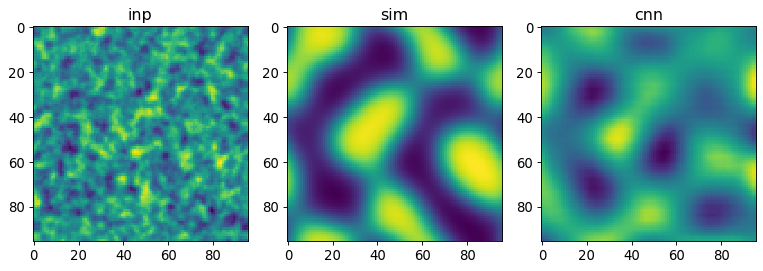

tensor(0.4742, device='cuda:0', dtype=torch.float64)


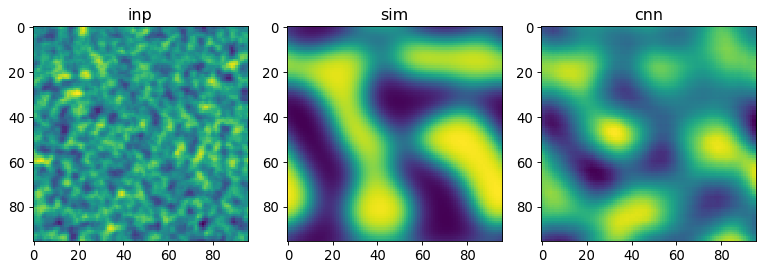

tensor(0.5039, device='cuda:0', dtype=torch.float64)
CPU times: user 331 ms, sys: 868 ms, total: 1.2 s
Wall time: 1.22 s


In [33]:
%%time
x_val, y_val = data_generator(nsamples=2, 
                              dim_x=96, 
                              init_steps=init_steps, 
                              delta_sim_steps = delta_sim_steps,
                              dx = dx, 
                              dt = dt,
                              gamma=gamma, 
                              seed =174753,
                              device = device)

val_dataset = CahnHillDataset(x_val, y_val, transform_x=transformer_x, transform_y=transformer_y)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)



ix = 0
for ix in range(2):
    item_v = val_dataset[ix]
    x1 = item_v['x'][None].to(device)
    y1 = item_v['y'][None].to(device)
    model.eval()
    y2, _ = model(x1)

    im_x1 = x1[0].detach().cpu().numpy()
    im_y1 = y1[0].detach().cpu().numpy()
    im_y2 = y2[0].detach().cpu().numpy()
    
    utils.draw_by_side([im_x1[0], im_y1[0], im_y2[0]], sub_titles=["inp", "sim", "cnn"])
    print(rmse_loss(y1, y2).data)


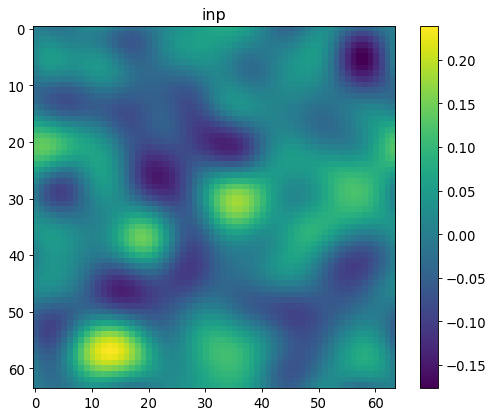

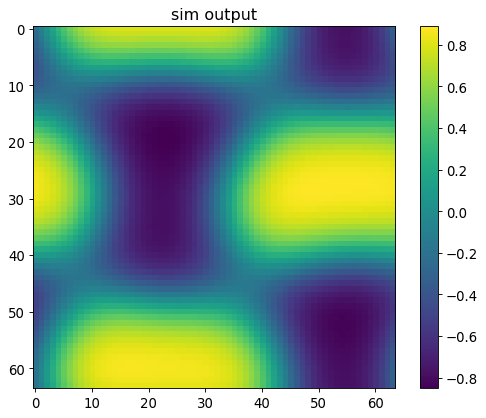

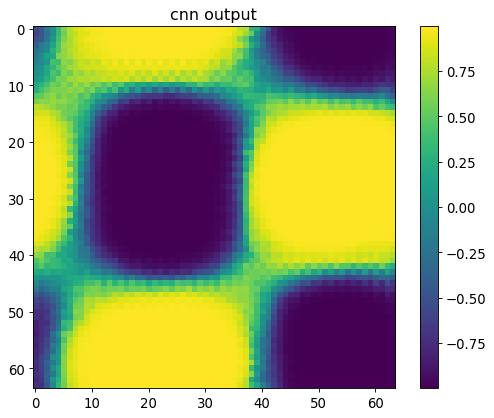

tensor(0.2077, device='cuda:0', dtype=torch.float64)


In [30]:
ix = 12

item_prd = val_dataset[ix]
x1 = item_prd['x'].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(y1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

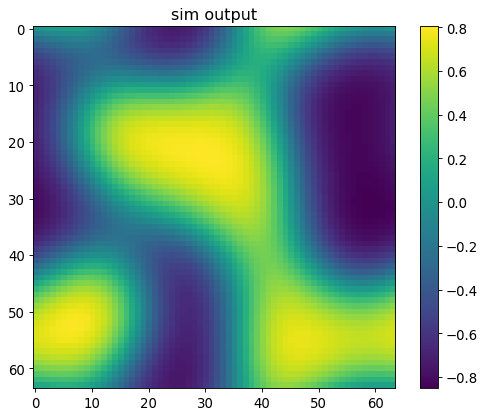

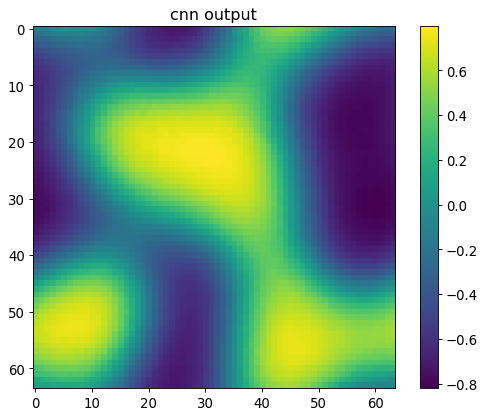

tensor(0.0025, device='cuda:0', dtype=torch.float64)


In [34]:
ix = 12

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

# draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

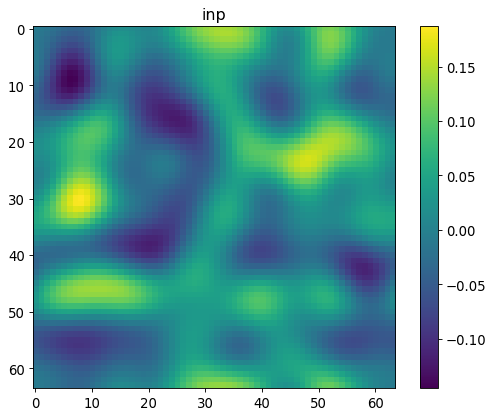

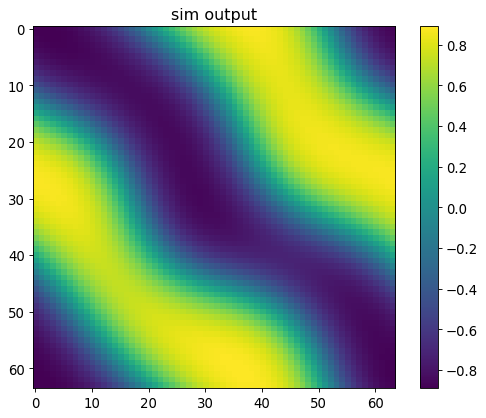

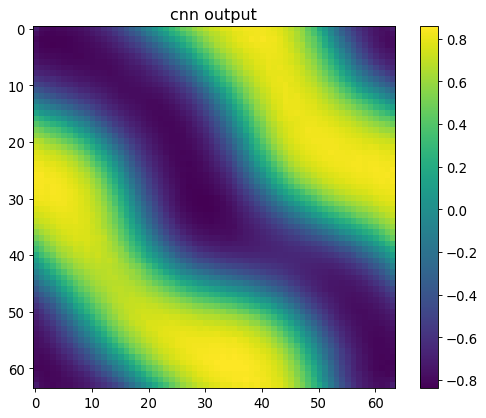

tensor(0.0019, device='cuda:0', dtype=torch.float64)


In [35]:
ix = 3

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)

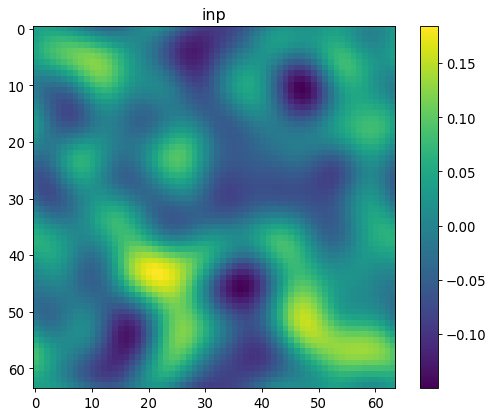

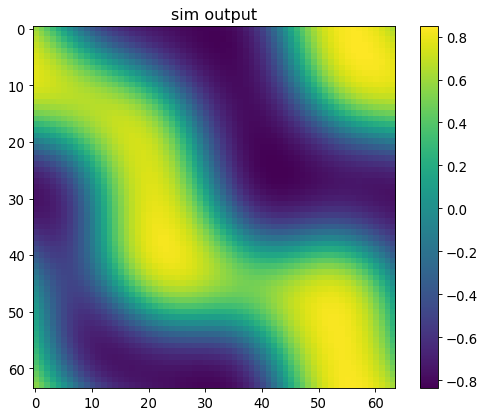

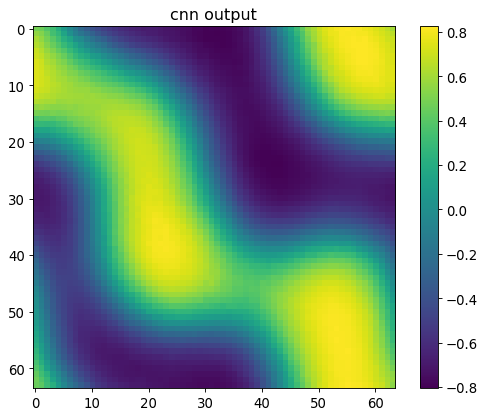

tensor(0.0017, device='cuda:0', dtype=torch.float64)


In [36]:
ix = 15

item_prd = prd_dataset[ix]
x1 = item_prd['x'][None].to(device)
y1 = item_prd['y'][None].to(device)
y2 = model(x1)

im_x1 = x1[0].detach().cpu().numpy()
im_y1 = y1[0].detach().cpu().numpy()
im_y2 = y2[0].detach().cpu().numpy()

draw_im(im_x1, "inp")
draw_im(im_y1, "sim output")
draw_im(im_y2, "cnn output")

print(mse_loss(y1, y2).data)